In [1]:
%load_ext lab_black

In [2]:
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import polars as pl
import seaborn as sns
import sys
import tensorflow as tf
import wandb
import xarray as xr
from dataclasses import dataclass, field
from hydra import compose, initialize
from hydra.utils import call, instantiate
from icecream import ic
from matplotlib_functions import setMatplotlibParam
from mpl_toolkits.axes_grid1 import make_axes_locatable
from omegaconf import DictConfig, OmegaConf
from sklearn import preprocessing
from tensorflow import keras
from typing import List, Optional
from wandb.keras import WandbCallback, WandbMetricsLogger
from rich.progress import Progress
import include.callbacks as callbacks
import include.generators as generators
import include.loss as loss
import include.optimisers as optimisers
import model_eval
import models.reg as rm
from Data import Data_eval, Data_train
from include.callbacks import ExtraValidation, get_modelcheckpoint, initiate_wb
from include.generators import InvDataGen
from model_training import Model_training_manager, Trainer
from models.preprocessing import CloudsLayer, ConditionalNoiseLayer
from saver import Saver

import matplotlib_functions as mympf

import oco3_utils
import importlib

setMatplotlibParam()
plt.viridis()

2024-02-19 15:13:25.697487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 15:13:25.697527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 15:13:25.697550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-19 15:13:25.704349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: ERROR Unable to patch Tensorflow/Ke

<Figure size 1920x1440 with 0 Axes>

In [3]:
importlib.reload(oco3_utils)

<module 'oco3_utils' from '/cerea_raid/users/dumontj/dev/coco2/inv/notebooks/oco3_utils.py'>

In [4]:
dir_res = "/libre/dumontj/coco2/weights/new"
dir_ds = "/libre/dumontj/coco2/dl-input"

## Infos on OCO3

In [5]:
name_eval_nc = "oco3/dataset.nc"
ds = xr.open_dataset(os.path.join(dir_ds, name_eval_nc))
ds

<xarray.Dataset>
Dimensions:       (idx_img: 39, y: 32, x: 32, hour_prec: 3)
Coordinates:
  * idx_img       (idx_img) int32 0 1 2 3 4 5 6 7 8 ... 31 32 33 34 35 36 37 38
  * y             (y) int32 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * x             (x) int32 0 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
Dimensions without coordinates: hour_prec
Data variables:
    point_source  (idx_img) object ...
    time          (idx_img) datetime64[ns] ...
    biased_xco2   (idx_img, y, x) float32 ...
    xco2          (idx_img, y, x) float32 ...
    xco2_noisy    (idx_img, y, x) float32 ...
    lats          (idx_img, y, x) float32 ...
    lons          (idx_img, y, x) float32 ...
    emiss         (idx_img, hour_prec) float32 ...
    all_v         (idx_img, y, x, hour_prec) float64 ...
    all_u         (idx_img, y, x, hour_prec) float64 ...
    v             (idx_img, y, x) float64 ...
    u             (idx_img, y, x) float64 ...
Attributes:
    description:  Anthropogenic XCO2 plume related data
    N_img:        39

## Model

In [59]:
name_model = "inv_lip_test_32_sweep_save/4"
name_model = "inv_lip_test_32_sweep_save/8"
# name_model = "inv_lip_test_32_sweep_save/16"
name_model = "inv_oco3_32_sweep/3"

name_valid_nc = "2km_Dolo_32/dataset.nc"
name_valid_2_nc = "2km_Dolo_32_beta_distribution_mapping/dataset.nc"
# name_valid_2_nc = "2km_Dolo_32_uniform_distribution_mapping/dataset.nc"
name_extra_valid_nc = "oco3/dataset.nc"
name_eval_nc = "oco3/dataset.nc"

path_valid_1_nc = os.path.join(dir_ds, name_valid_nc)
path_valid_2_nc = os.path.join(dir_ds, name_valid_2_nc)
path_extra_valid_nc = os.path.join(dir_ds, name_extra_valid_nc)

In [60]:
name_model

'inv_oco3_32_sweep/3'

In [61]:
cfg = OmegaConf.load(os.path.join(dir_res, name_model, "config.yaml"))

In [62]:
cfg

{'data': {'init': {'_target_': 'Data.Data_train', 'path_train_ds': '${data.path.directory}/${data.path.train.name}/${data.path.train.nc}', 'path_valid_ds': '${data.path.directory}/${data.path.valid.name}/${data.path.valid.nc}', 'path_valid_2_ds': '${data.path.directory}/${data.path.valid_2.name}/${data.path.valid_2.nc}', 'path_extra_valid_ds': '${data.path.directory}/${data.path.extra_valid.name}/${data.path.extra_valid.nc}'}, 'input': {'dir_seg_models': '/cerea_raid/users/dumontj/dev/coco2/dl/res/models', 'chan_0': 'xco2', 'chan_1': 'u_wind', 'chan_2': 'v_wind', 'chan_3': 'None', 'chan_4': 'None', 'clouds_threshold': 0.5, 'dir_clouds_array': '/libre/dumontj/coco2/dl-input/clouds', 'timedate': True}, 'output': {'N_emissions': 1}, 'path': {'directory': '/libre/dumontj/coco2/dl-input', 'train': {'name': '2km_forOco3_32', 'nc': 'dataset.nc'}, 'valid': {'name': '2km_Dolo_32_beta_distribution_mapping', 'nc': 'dataset.nc'}, 'valid_2': {'name': '2km_Dolo_32', 'nc': 'dataset.nc'}, 'extra_valid

In [63]:
model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_last.h5"
)

## Valid 1 data

In [39]:
data_v1 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_valid_1_nc
)

ic| self.eval.shape: (4296, 32, 32, 3)


In [40]:
eval_v1 = model_eval.InversionModelEvaluation(model=model, data=data_v1)
metrics = eval_v1.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.1102629
mape: 40.489555


In [41]:
get_summary_histo_inversion(model, data_v1)

NameError: name 'get_summary_histo_inversion' is not defined

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


nwbce: 0.18468236923217773
idx: 1129
origin: smart_2km_Dolo_32
time: 2015-04-05T03:00:00.000000000
emiss: [5.260922 4.669042 5.236865]

nwbce: 1.4749693870544434
idx: 1894
origin: smart_2km_Dolo_32
time: 2015-06-07T21:00:00.000000000
emiss: [4.751152 5.453055 5.507097]

nwbce: 3.2778825759887695
idx: 1926
origin: smart_2km_Dolo_32
time: 2015-06-10T13:00:00.000000000
emiss: [8.048671 8.19111  8.618435]

nwbce: 1.2053427696228027
idx: 1220
origin: smart_2km_Dolo_32
time: 2015-04-12T17:00:00.000000000
emiss: [6.70789  7.036716 7.431201]



<Figure size 1920x1440 with 0 Axes>

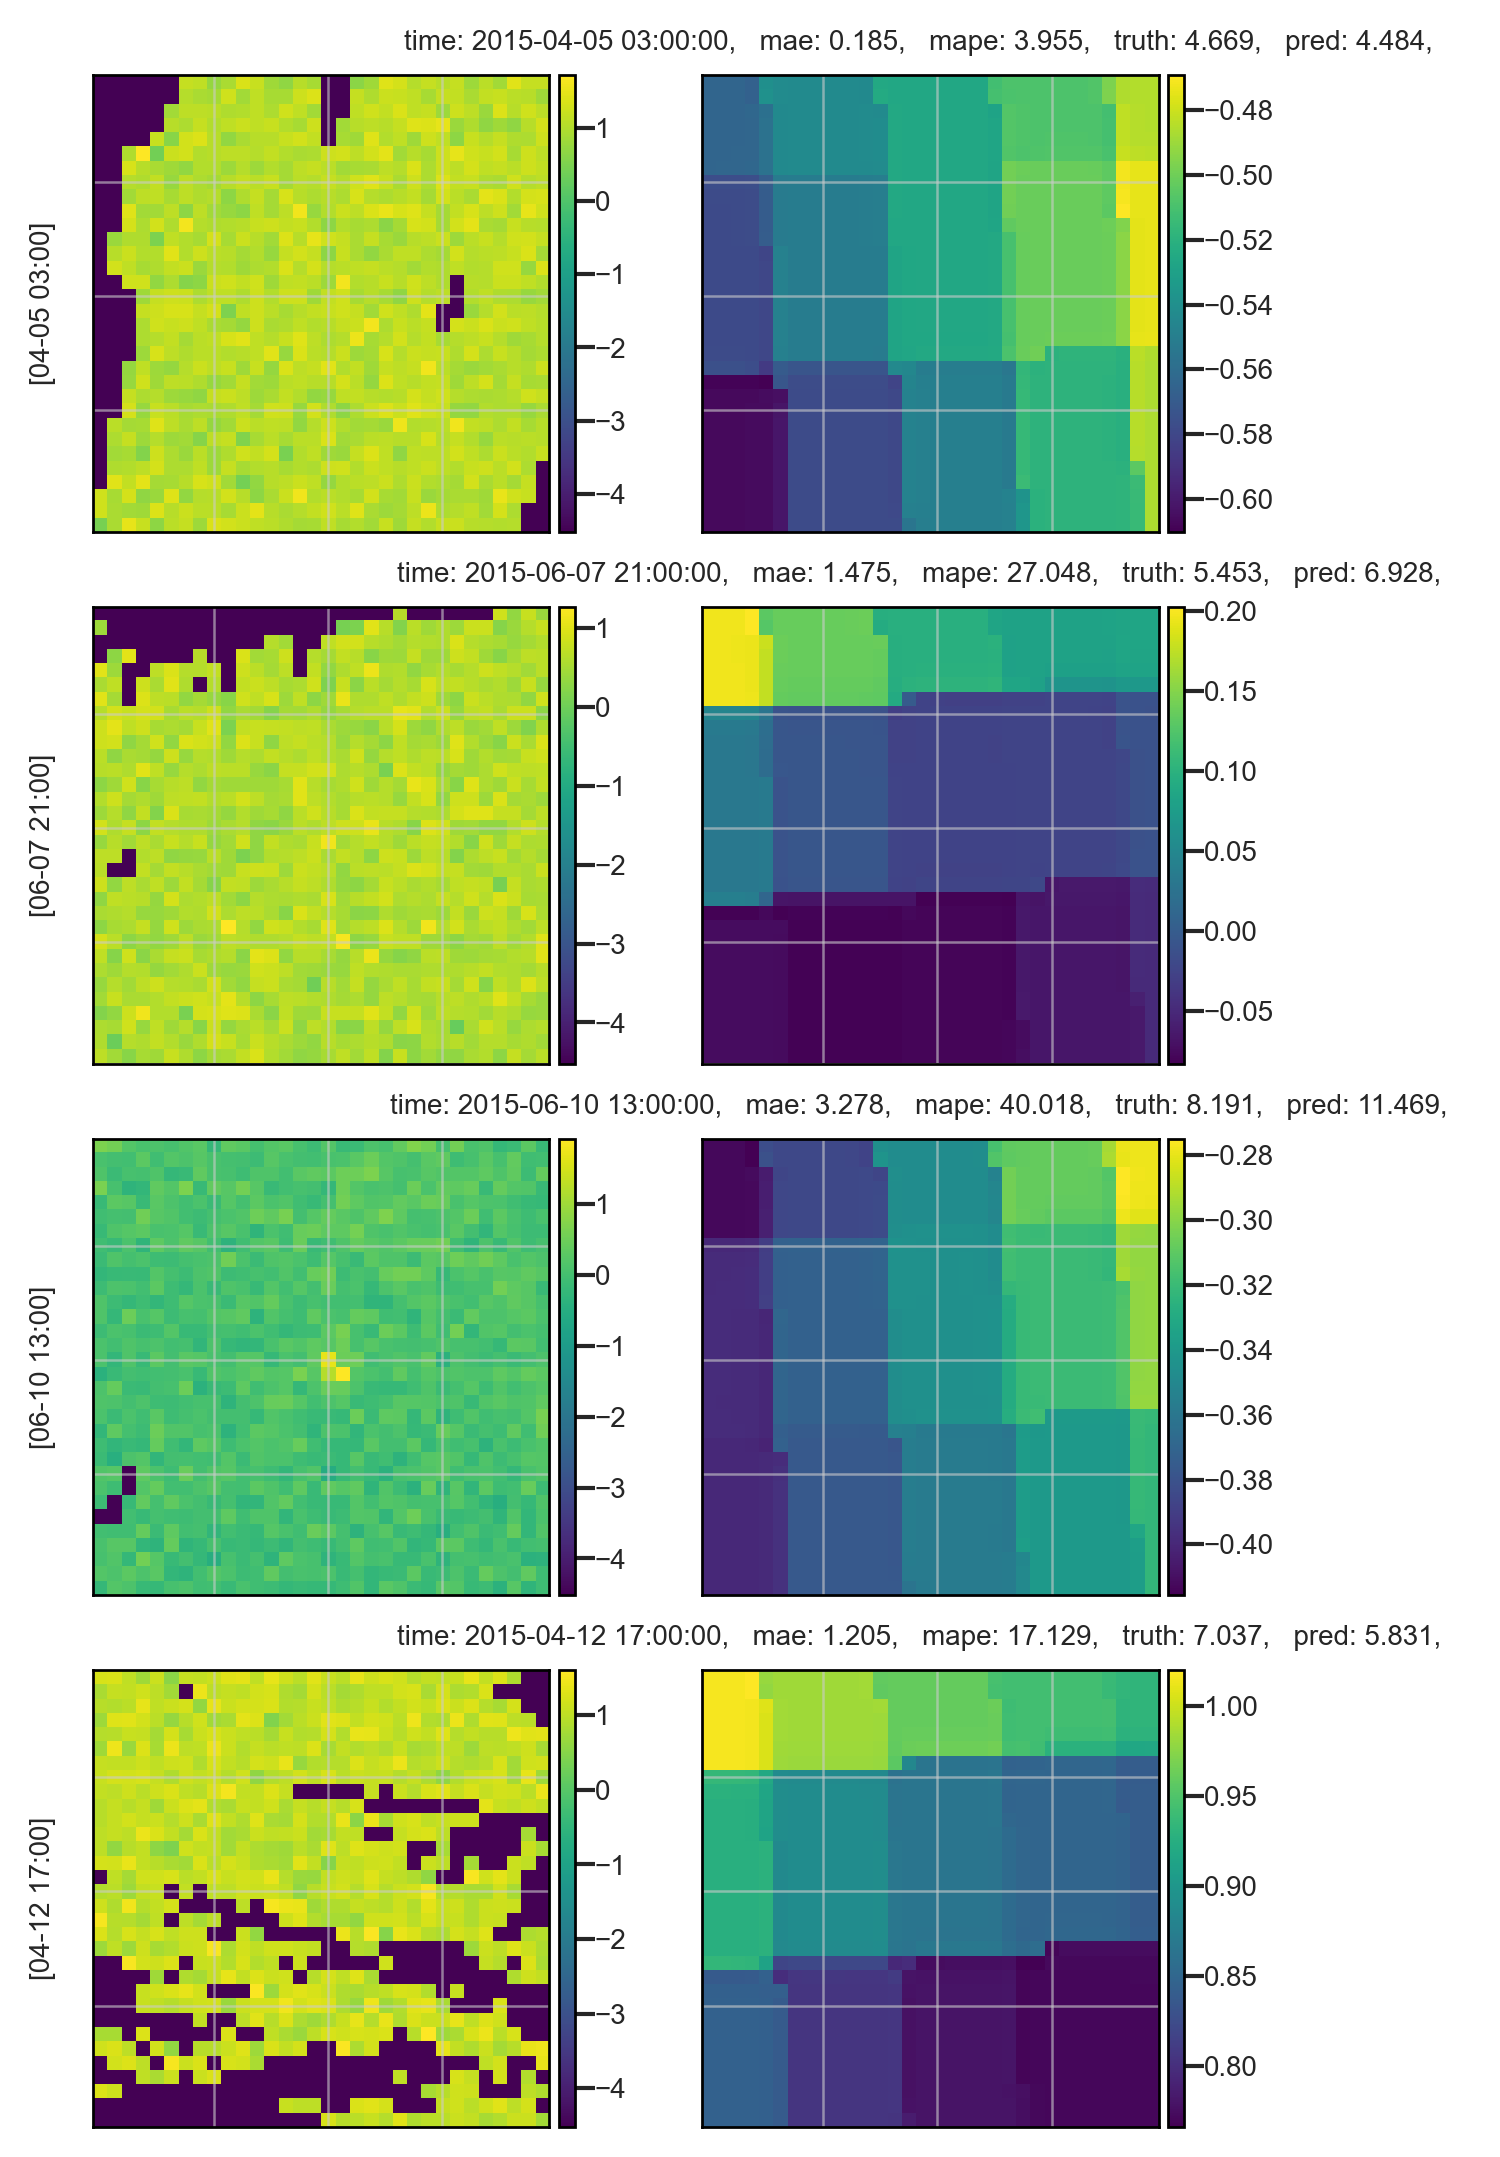

In [56]:
inv_plotter = model_eval.InversionPlotter(eval_v1, winds_as_input=False)
inv_plotter.plot_examples()

## Valid 2 data

In [57]:
data_v2 = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_valid_2_nc
)

ic| self.eval.shape: (4296, 32, 32, 3)


In [58]:
eval_v2 = model_eval.InversionModelEvaluation(model=model, data=data_v2)
metrics = eval_v2.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 4.4085603
mape: 100.36518


135/135 [==============================] - 1s 4ms/step


<Figure size 1920x1440 with 0 Axes>

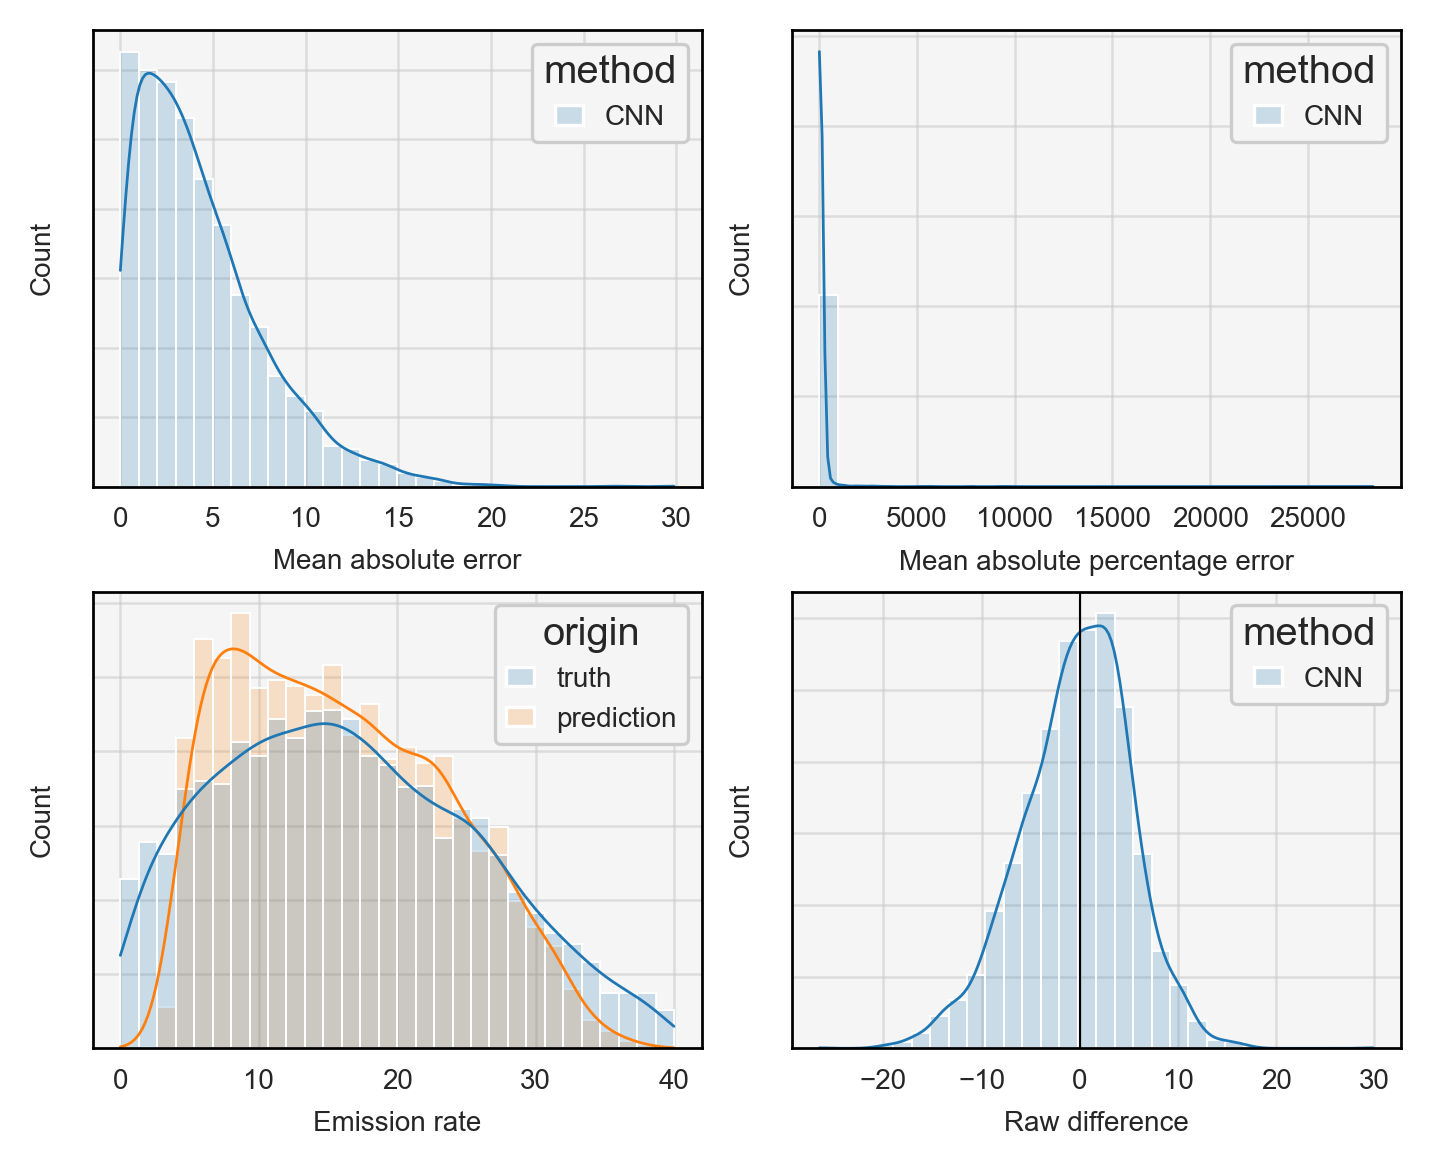

In [59]:
get_summary_histo_inversion(model, data_v2)

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


nwbce: 9.204049110412598
idx: 938
origin: smart_2km_Dolo_32
time: 2015-03-20T05:00:00.000000000
emiss: [18.352083 14.760886 14.361926]

nwbce: 5.361187934875488
idx: 3888
origin: smart_2km_Dolo_32
time: 2015-11-21T01:00:00.000000000
emiss: [ 7.7290387 10.115143  12.29197  ]

nwbce: 1.1122493743896484
idx: 2808
origin: smart_2km_Dolo_32
time: 2015-08-23T01:00:00.000000000
emiss: [5.5513215 6.226452  7.610117 ]

nwbce: 13.876070022583008
idx: 630
origin: smart_2km_Dolo_32
time: 2015-02-22T13:00:00.000000000
emiss: [14.58073  14.964422 15.476173]



<Figure size 1920x1440 with 0 Axes>

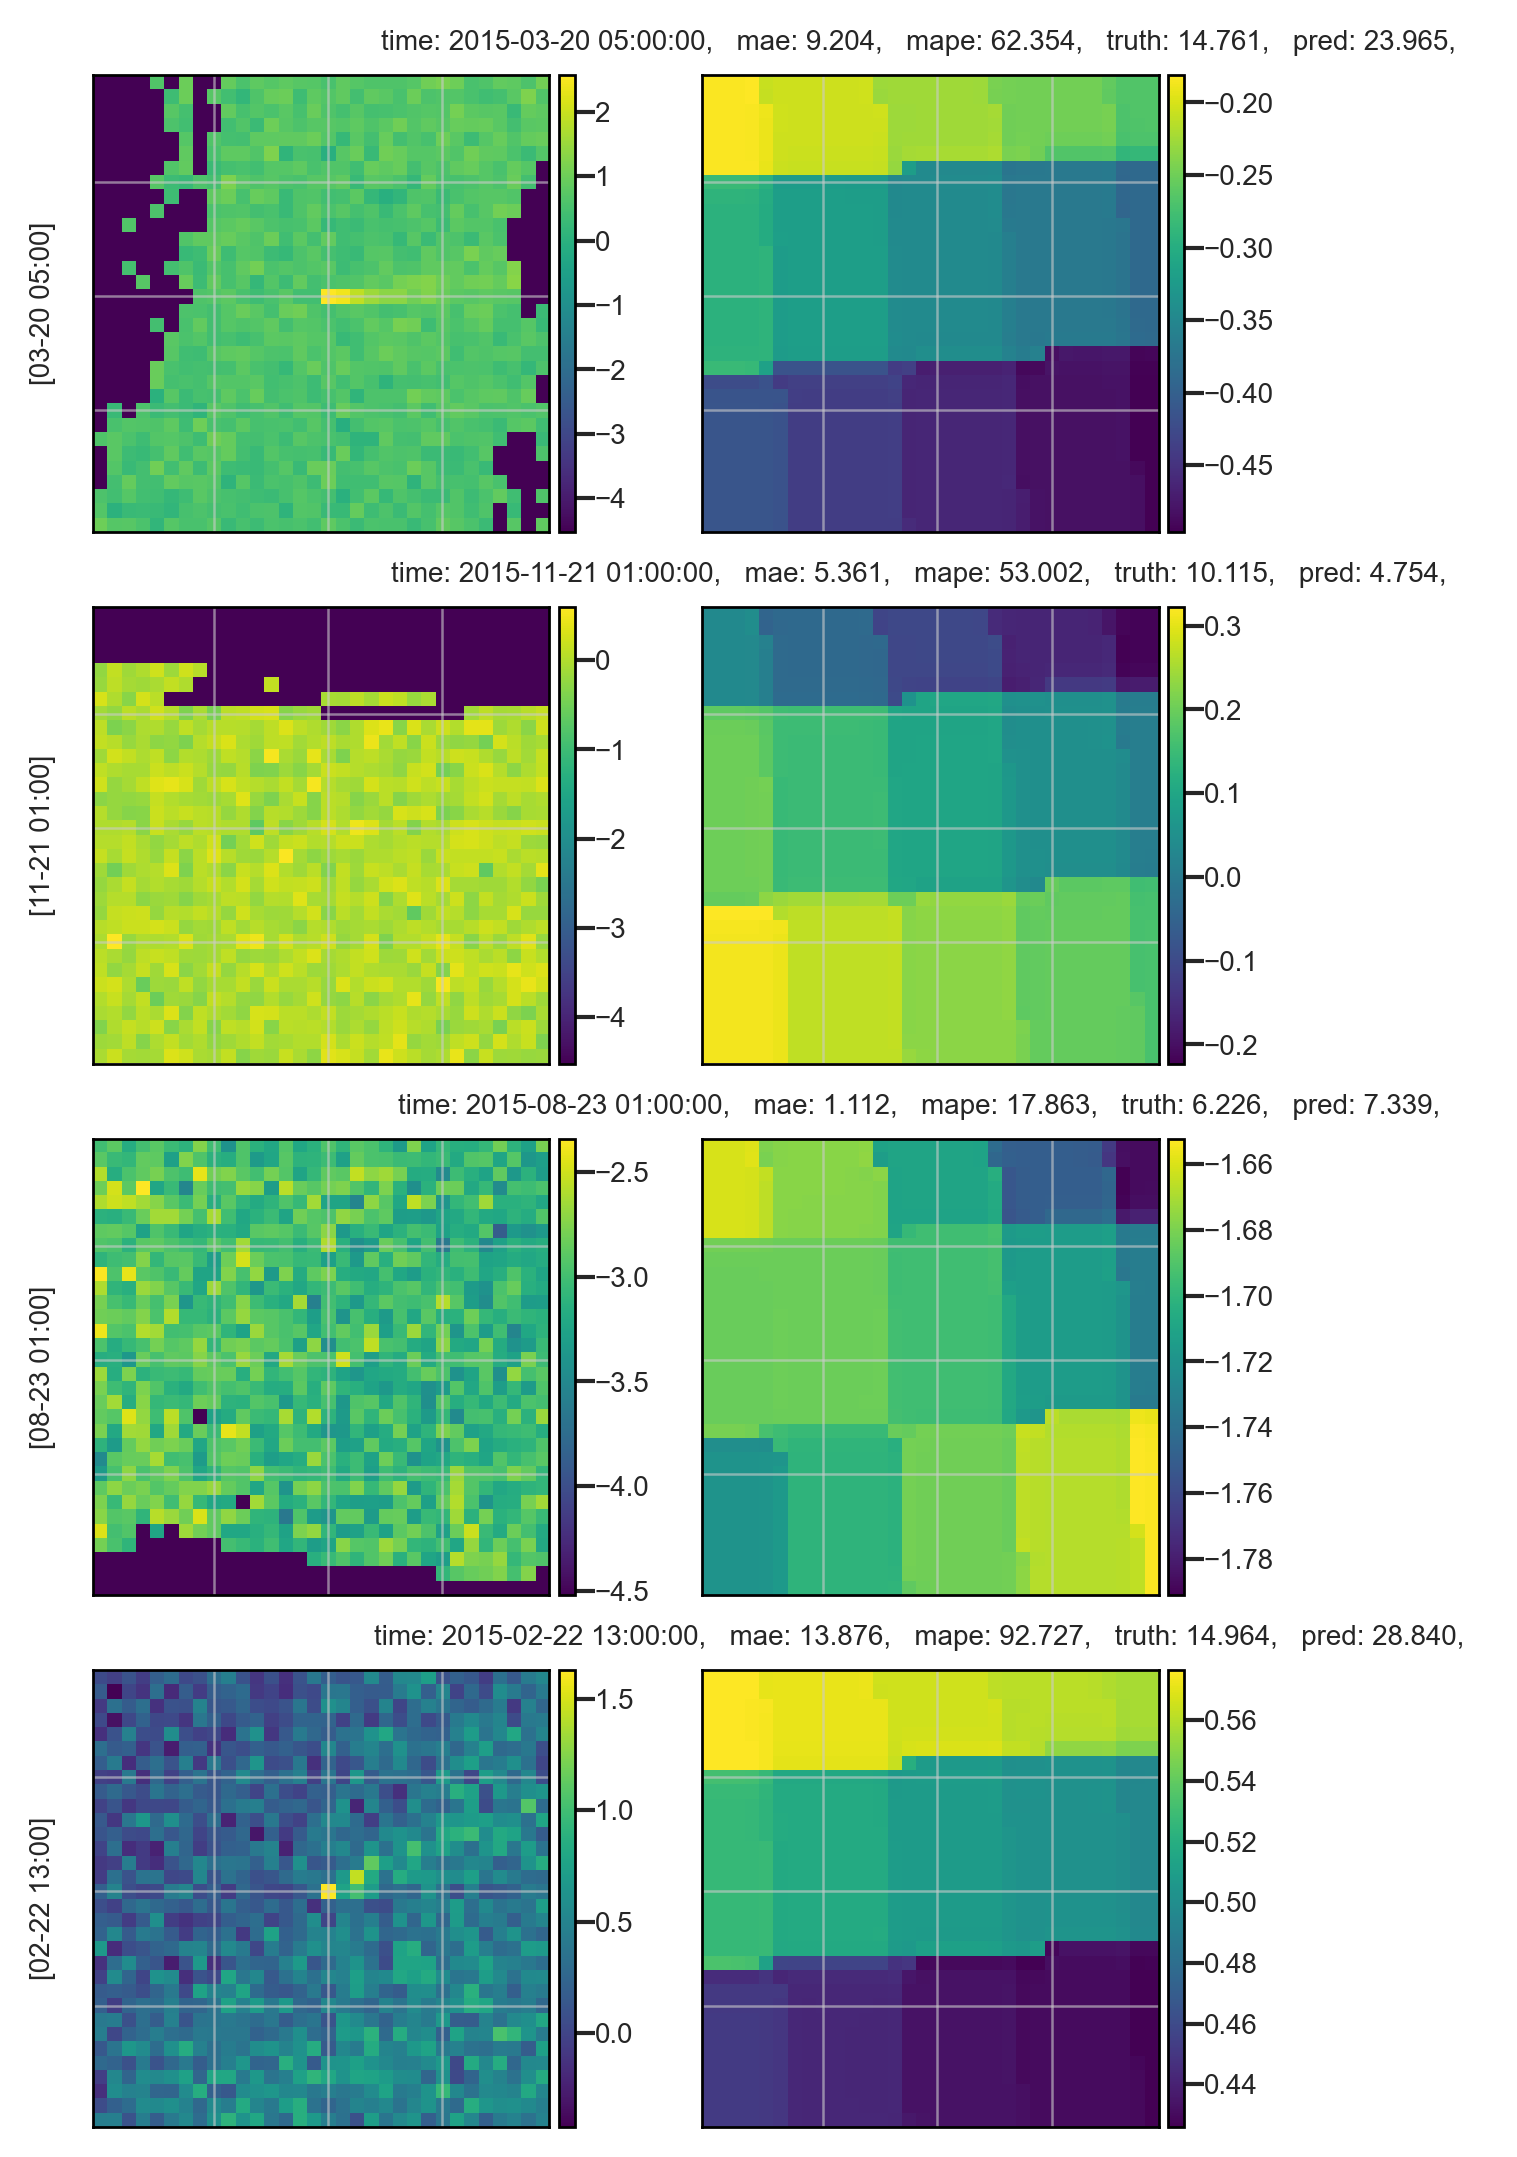

In [60]:
inv_plotter = model_eval.InversionPlotter(eval_v2, winds_as_input=False)
inv_plotter.plot_examples()

## Extra_valid data

### Study results

In [64]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_extra_valid_nc, cloud_threshold=0.99
)

ic| self.eval.shape: (39, 32, 32, 3)


In [65]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 7.0235095
mape: 51.31258


In [58]:
print(np.c_[inv_eval.pred, inv_eval.y])

[[12.93265057 13.60000038]
 [15.20033646 13.60000038]
 [12.82091045 13.60000038]
 [ 7.84818316 13.60000038]
 [29.50531769 37.59999847]
 [23.23783875 37.59999847]
 [25.14661026 37.59999847]
 [24.88140106 37.59999847]
 [22.64125061 30.        ]
 [16.69042015 30.        ]
 [20.66275215 30.        ]
 [17.68450356 30.        ]
 [20.32964897 30.        ]
 [24.75999451 30.        ]
 [14.29172802 30.        ]
 [24.61964607 30.        ]
 [ 9.46948242 12.37349987]
 [13.89780617 12.37349987]
 [ 8.75234413 12.37349987]
 [ 7.44734192 14.96500015]
 [10.79767323 14.96500015]
 [11.69740009 14.96500015]
 [10.18118572 14.96500015]
 [ 8.52196407 14.96500015]
 [ 4.25502968 14.96500015]
 [ 5.70095205  5.03700018]
 [13.07443428  5.03700018]
 [ 9.23643589  7.19049978]
 [ 9.31660175  7.19049978]
 [21.91971779  7.19049978]
 [11.02571964  7.19049978]
 [22.16768646  7.19049978]
 [35.38097     7.19049978]
 [ 8.78614235  7.19049978]
 [11.69333076 13.17650032]
 [22.79206657 13.17650032]
 [ 6.62316418 13.17650032]
 

In [50]:
inv_eval.pred[0:8]

array([[14.0351  ],
       [16.688988],
       [ 9.848979],
       [11.598859],
       [27.973671],
       [25.676075],
       [29.663576],
       [27.162403]], dtype=float32)

In [30]:
inv_eval.pred[8:16]

array([[22.278984],
       [18.132618],
       [23.373468],
       [19.188452],
       [18.561897],
       [22.145664],
       [15.990159],
       [25.380623]], dtype=float32)

In [31]:
data.ds.point_source.values

array(['Colstrip', 'Colstrip', 'Colstrip', 'Colstrip', 'Belchatow',
       'Belchatow', 'Belchatow', 'Belchatow', 'Tuoketo', 'Tuoketo',
       'Tuoketo', 'Tuoketo', 'Tuoketo', 'Tuoketo', 'Tuoketo', 'Tuoketo',
       'Cumberland', 'Cumberland', 'Cumberland', 'Labadie', 'Labadie',
       'Labadie', 'Labadie', 'Labadie', 'Labadie', 'Intermountain',
       'Intermountain', 'Hunters', 'Hunters', 'Hunters', 'Hunters',
       'Hunters', 'Hunters', 'Hunters', 'Parish', 'Parish', 'Parish',
       'Parish', 'Conemaugh'], dtype=object)

ic| data_v1.y.eval[idx_img, 0]: 12.069396018981934
ic| data_v1.y.eval[idx_img, 0]: 15.79891300201416
ic| data_v1.y.eval[idx_img, 0]: 19.607755661010742
ic| data_v1.y.eval[idx_img, 0]: 9.040684700012207
ic| data_v1.y.eval[idx_img, 0]: 18.51962661743164
ic| data_v1.y.eval[idx_img, 0]: 10.513147354125977
ic| data_v1.y.eval[idx_img, 0]: 23.923675537109375
ic| data_v1.y.eval[idx_img, 0]: 16.840944290161133
ic| data_v1.y.eval[idx_img, 0]: 2.5285234451293945
ic| data_v1.y.eval[idx_img, 0]: 12.571273803710938
ic| data_v1.y.eval[idx_img, 0]: 14.08137321472168
ic| data_v1.y.eval[idx_img, 0]: 4.75656270980835
ic| data_v1.y.eval[idx_img, 0]: 8.911600112915039
ic| data_v1.y.eval[idx_img, 0]: 28.476144790649414
ic| data_v1.y.eval[idx_img, 0]: 2.459873914718628
ic| data_v1.y.eval[idx_img, 0]: 7.861299991607666


<Figure size 1920x1440 with 0 Axes>

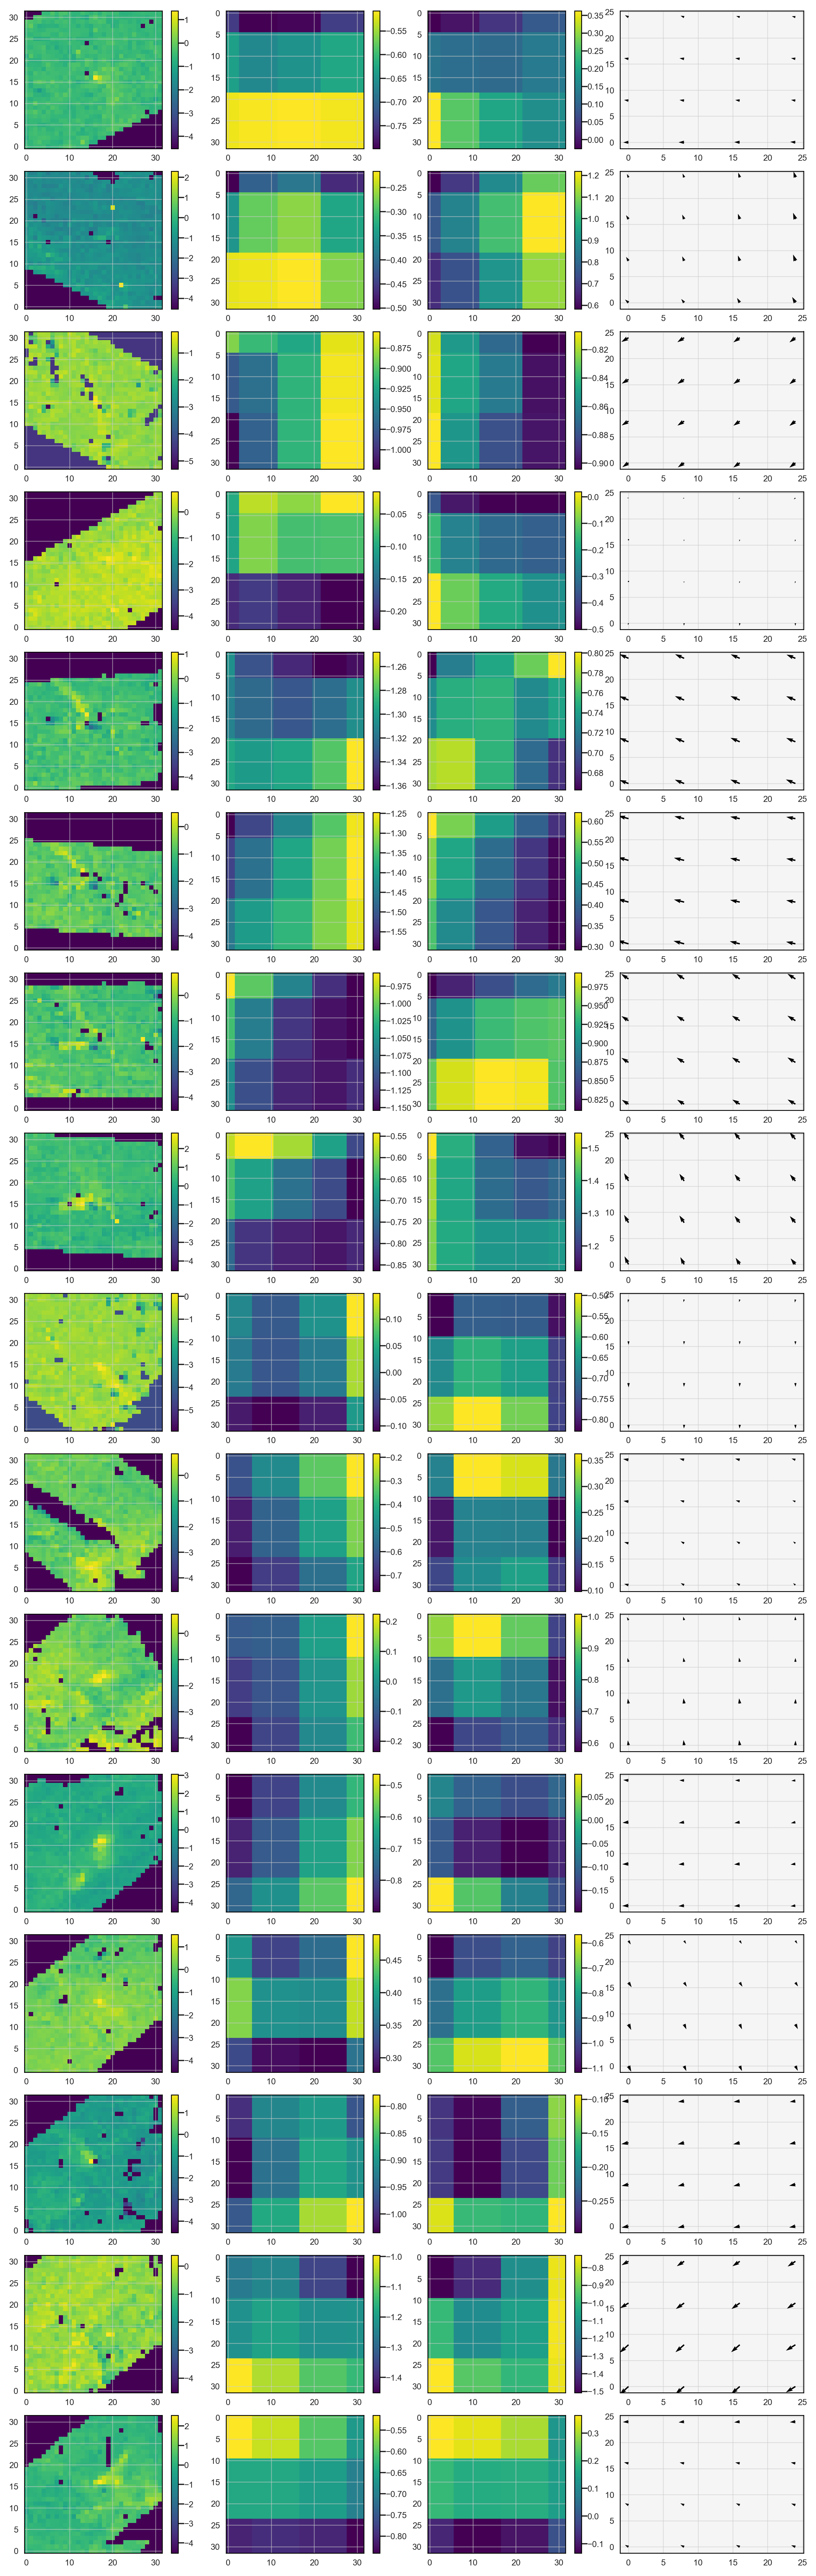

In [36]:
N_cols = 4
N_rows = 16
mympf.setMatplotlibParam()
plt.viridis()
axs = mympf.set_figure_axs(
    N_rows,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.2,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

for i, idx_img in enumerate(np.arange(0, 16)):
    ic(data_v1.y.eval[idx_img, 0])
    im = axs[0 + N_cols * i].imshow(data.x.eval[idx_img, ..., 0], origin="lower")
    plt.colorbar(im, ax=axs[0 + N_cols * i])
    im = axs[1 + N_cols * i].imshow(data.x.eval[idx_img, ..., 1])
    plt.colorbar(im, ax=axs[1 + N_cols * i])
    im = axs[2 + N_cols * i].imshow(data.x.eval[idx_img, ..., 2])
    plt.colorbar(im, ax=axs[2 + N_cols * i])

    step = 8
    axs[3 + N_cols * i].quiver(
        np.arange(0, 32, 1)[::step],
        np.arange(0, 32, 1)[::step],
        data.x.eval[idx_img, ::step, ::step, 1].numpy(),
        data.x.eval[idx_img, ::step, ::step, 2].numpy(),
        angles="xy",
        scale_units="xy",
        scale=1,
    )
    # im = axs[1, 1].imshow(v_my[idx_img])
    # plt.colorbar(im, ax=axs[1, 1])

ic| list_idx: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
                     17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
                     34, 35, 36, 37])


<Figure size 1920x1440 with 0 Axes>

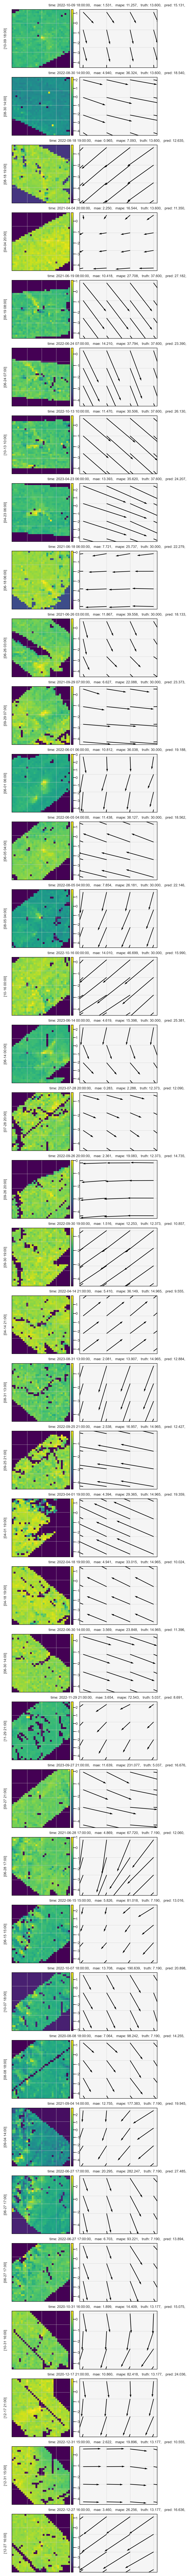

In [36]:
inv_plotter = model_eval.InversionPlotter(inv_eval)
inv_plotter.N_rows = 38
inv_plotter.plot_examples(list_idx=np.arange(0, 38))
# inv_plotter.plot_examples(interval=[0, 1])

In [ ]:
plot_data = data.x.eval[8:]
num_channels = plot_data.shape[-1]
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

for channel in range(num_channels):
    if channel == 2:
        continue

    plt.figure(figsize=(num_examples * 2, 4))  # Adjust figure size as needed
    for i, idx in enumerate(example_indices):
        ax = plt.subplot(1, num_examples, i + 1)
        im = ax.imshow(plot_data[idx, :, :, channel], cmap="viridis")
        plt.title(f"Channel {channel}, Example {i + 1}")
        plt.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

NameError: name 'num_examples' is not defined

In [34]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

2/2 [==============================] - 0s 4ms/step
mae: 6.8815613
mape: 53.521427


2/2 [==============================] - 0s 4ms/step


<Figure size 1920x1440 with 0 Axes>

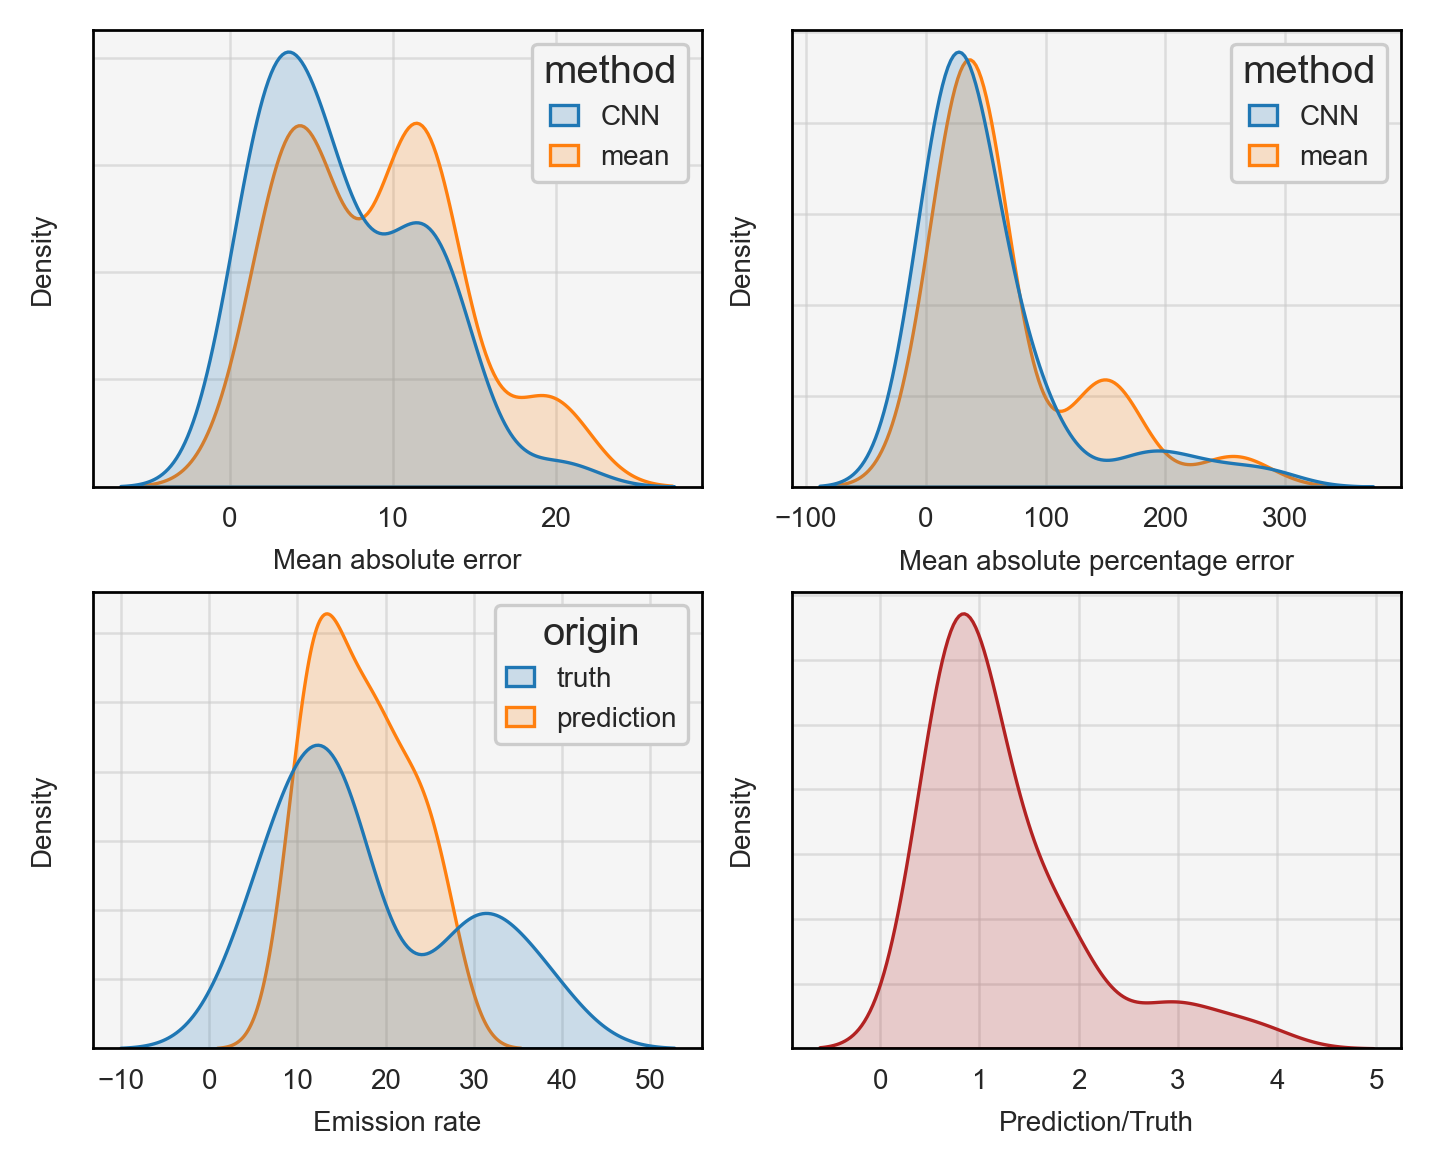

In [33]:
model_eval.get_summary_histo_inversion(model, data)

### Plot results (worst)

In [21]:
def count_and_get_images_in_quantile_range(metrics, lower_quantile, upper_quantile):
    lower_bound = np.quantile(metrics, lower_quantile)
    upper_bound = np.quantile(metrics, upper_quantile)
    filtered_metrics = metrics[(metrics >= lower_bound) & (metrics <= upper_bound)]
    count = len(filtered_metrics)
    return count, filtered_metrics


count, values = count_and_get_images_in_quantile_range(metrics["mae"], 0.0, 1)

### Plot integrated gradients

In [31]:
def get_integ_grad(data: Data_eval, idx: int = None):
    if not idx:
        idx = np.random.choice(data.ds.attrs["N_img"])
    x = tf.cast(data.x.eval[idx : idx + 1], tf.float32)
    baseline_tensor = tf.zeros_like(x)
    integ_grad = model_eval.integrated_gradients(model, x, baseline_tensor).numpy()
    return idx, integ_grad

In [46]:
(idx0, integ_grad_0) = get_integ_grad(data)
(idx1, integ_grad_1) = get_integ_grad(data)
(idx2, integ_grad_2) = get_integ_grad(data)
(idx3, integ_grad_3) = get_integ_grad(data)

In [47]:
plume = np.array(data.x.ds_eval.plume)

In [48]:
list_idx = [idx0, idx1, idx2, idx3]
list_data = [data, data, data, data]
list_plume = [plume, plume, plume, plume]
list_integ_grad = [
    integ_grad_0,
    integ_grad_1,
    integ_grad_2,
    integ_grad_3,
]
list_sources = ["Lippendorf", "Lippendorf", "Lippendorf", "Lippendorf"]

<Figure size 1920x1440 with 0 Axes>

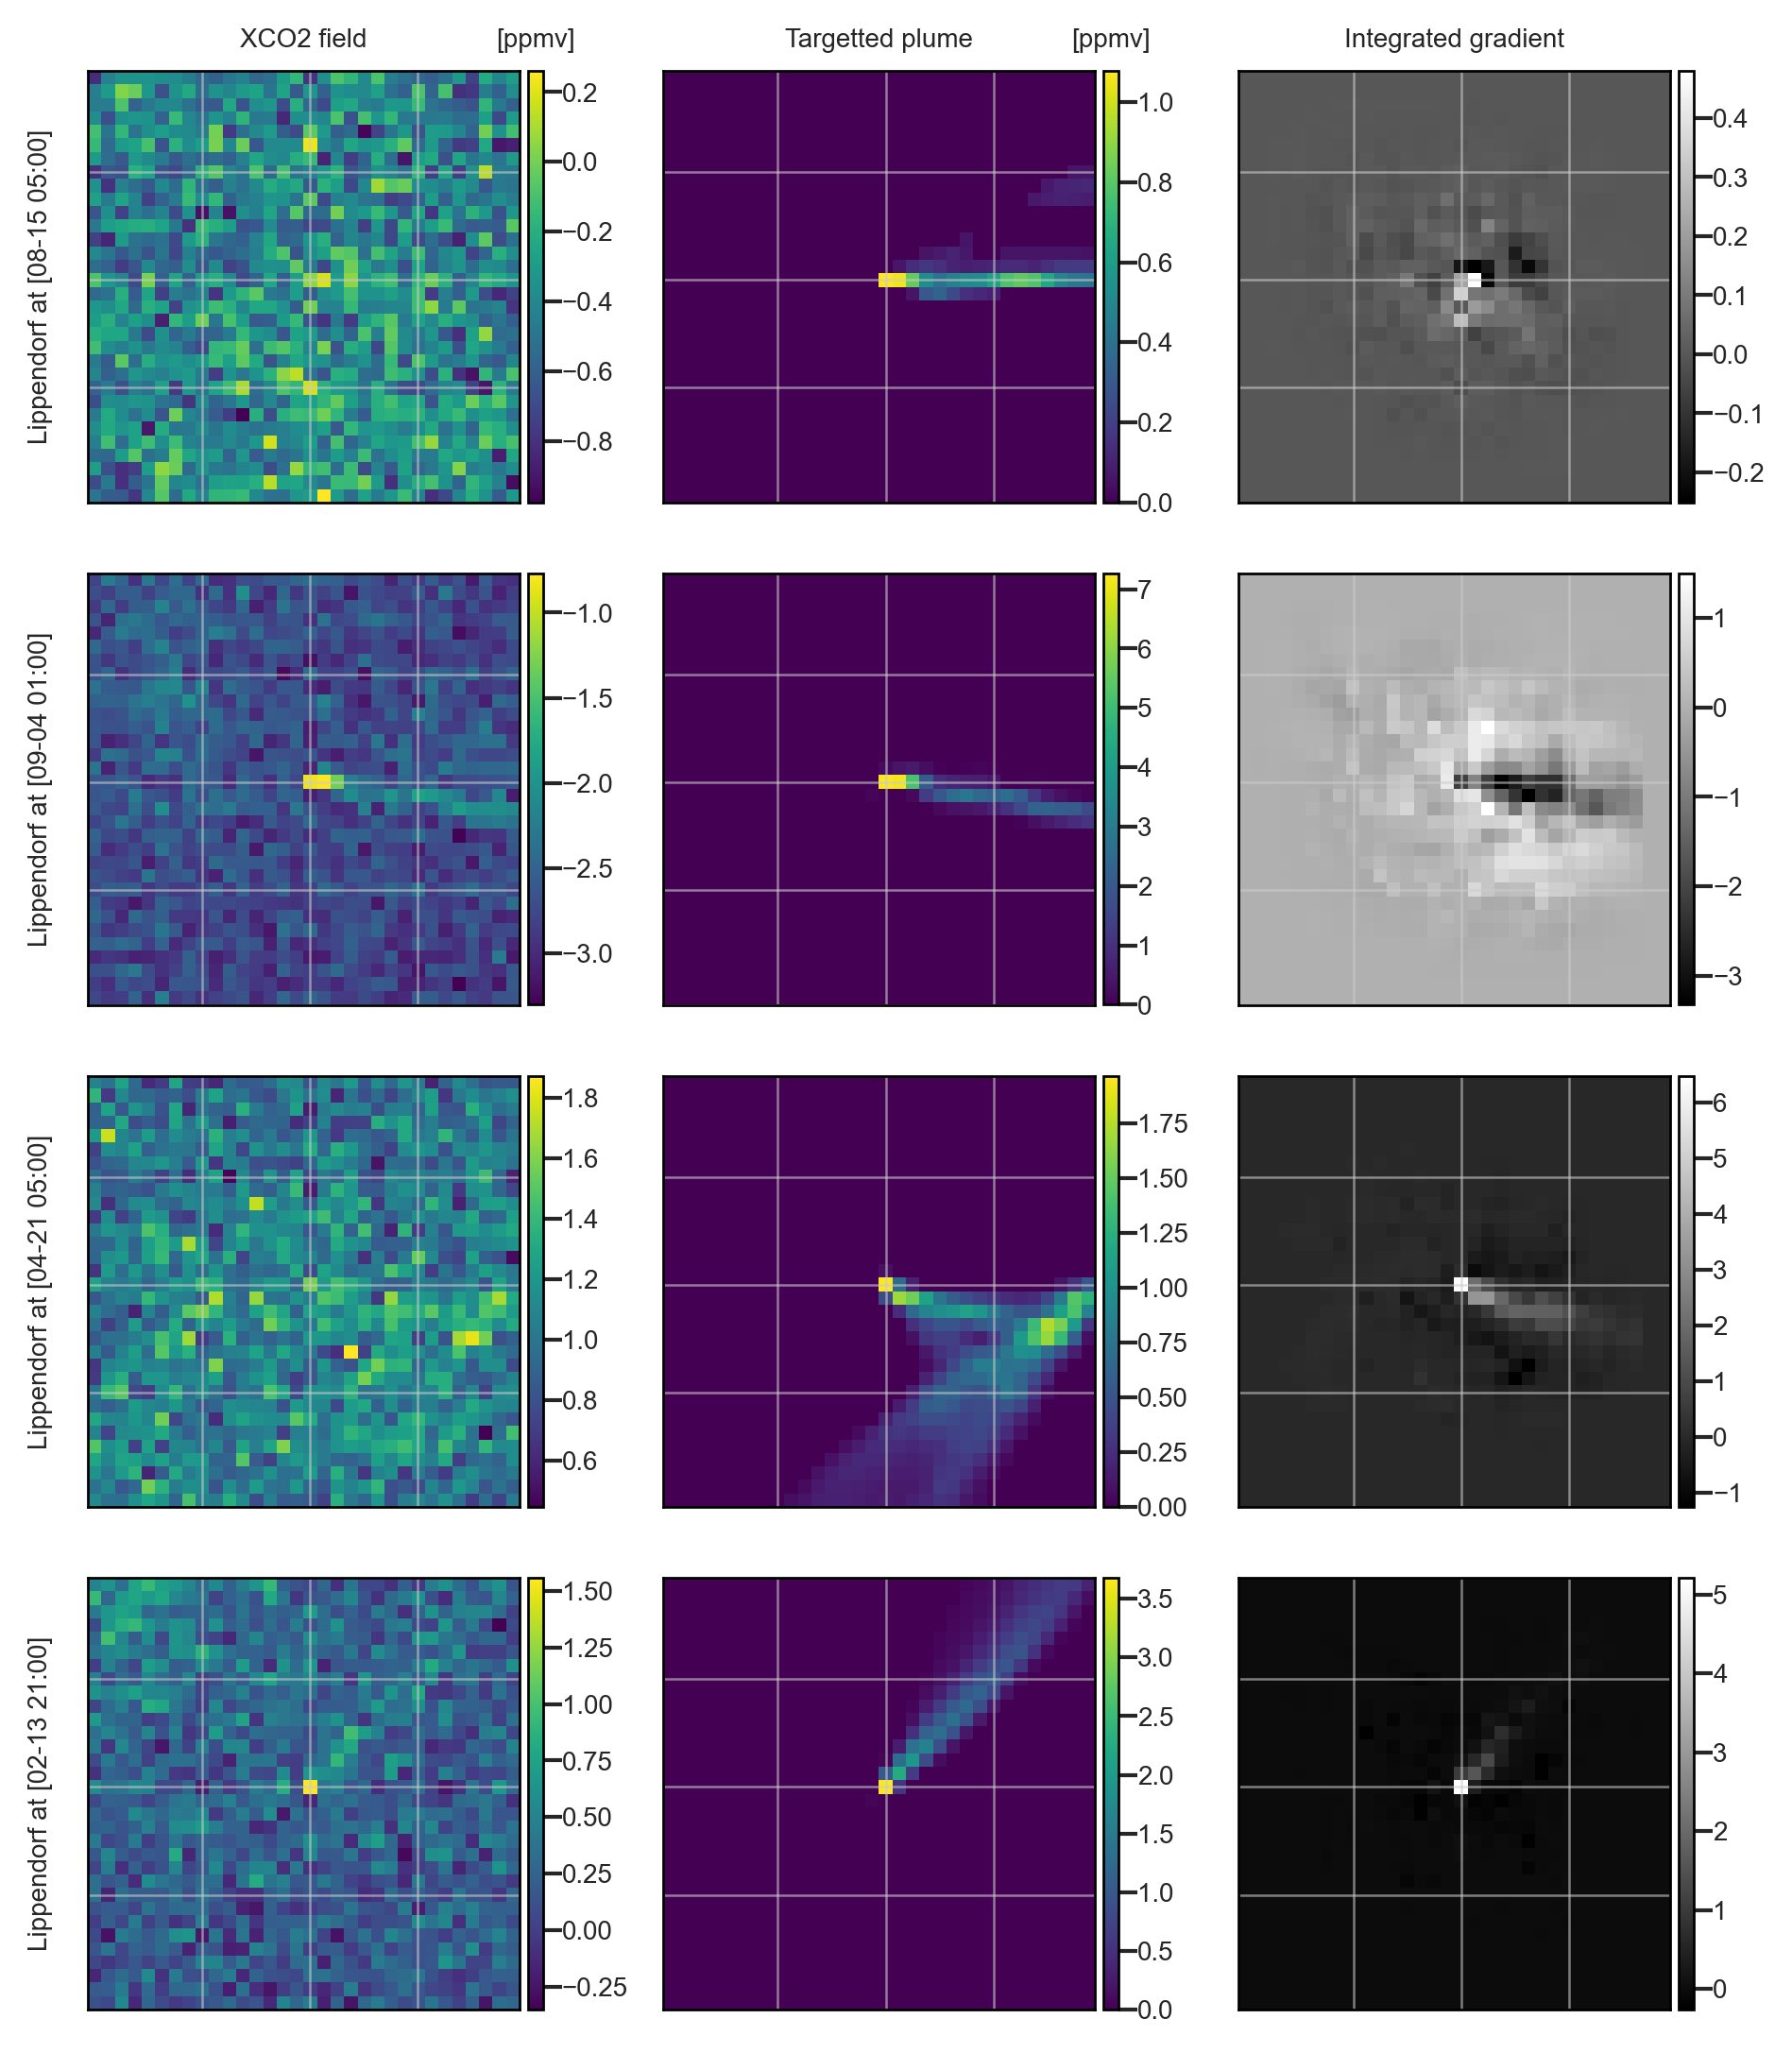

In [49]:
N_idx = 4
N_cols = 3
mympf.setMatplotlibParam(target="pres")
plt.viridis()
axs = mympf.set_figure_axs(
    N_idx,
    N_cols,
    wratio=0.35,
    hratio=0.75,
    pad_w_ext_left=0.25,
    pad_w_ext_right=0.25,
    pad_w_int=0.001,
    pad_h_ext=0.2,
    pad_h_int=0.25,
)

ims = [None] * (N_idx * N_cols)
caxs = [None] * (N_idx * N_cols)
cbars = [None] * (N_idx * N_cols)

Ny = int(data.x.eval.shape[1])
Nx = int(data.x.eval.shape[2])
for ax in axs:
    ax.set_xticks([int(Ny / 4), int(Ny / 2), int(Ny * 3 / 4)])
    ax.set_yticks([int(Nx / 4), int(Nx / 2), int(Nx * 3 / 4)])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

for i_row, (idx, data, plume, integ_grad) in enumerate(
    zip(list_idx, list_data, list_plume, list_integ_grad)
):
    for i_col, image in enumerate(
        [
            np.squeeze(data.x.eval[idx, :, :, 0]),
            np.squeeze(plume[idx, :, :]),
            np.squeeze(integ_grad[:, :, 0]),
        ]
    ):

        i_ax = i_col + i_row * N_cols
        ims[i_ax] = axs[i_ax].imshow(
            image, cmap="gray" if i_col == 2 else None, origin="lower"
        )
        caxs[i_ax] = axs[i_ax].inset_axes((1.02, 0, 0.035, 1))

        cbars[i_ax] = plt.colorbar(ims[i_ax], caxs[i_ax], orientation="vertical")

list_pd_t = []
for (idx, data) in zip(list_idx, list_data):
    list_pd_t.append(pd.Timestamp(data.ds.sel(idx_img=idx).time.values))

for i, (pd_t_idx, source) in enumerate(zip(list_pd_t, list_sources)):
    axs[i * N_cols].set_ylabel(
        f"{source} at [{pd_t_idx.month:02d}-{pd_t_idx.day:02d} {pd_t_idx.hour:02d}:00]"
    )

axs[0].set_title("XCO2 field")
axs[1].set_title("Targetted plume")
axs[2].set_title("Integrated gradient")

cbars[0].ax.set_title("[ppmv]")
cbars[1].ax.set_title("[ppmv]")

plt.show()

### Uncertainty quantification

#### Dropout

In [294]:
from keras.layers import Lambda
import keras.backend as K
from keras.models import Model
from keras.layers import Dropout, Input

In [295]:
def custom_dropout(x, level=0.2):
    return K.dropout(x, level=level)

##### Dropout à 0.2

In [303]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.2)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [304]:
predictions = []

for _ in range(50):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

 41/135 [========>.....................] - ETA: 0s

2024-01-15 18:23:20.945815: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_51/tf.nn.dropout_34/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 1s 5ms/step


In [305]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [306]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.9105513
mape: 26.7817


In [307]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 3.9291296
mape: 26.809132


In [308]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.        , -0.09244977],
       [-0.09244977,  1.        ]])

##### Dropout à 0.3

In [333]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.3)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [334]:
predictions = []

for _ in range(50):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

 40/135 [=======>......................] - ETA: 0s

2024-01-15 18:27:37.855943: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_54/tf.nn.dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 1s 5ms/step


In [335]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [336]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.8951368
mape: 26.723661


In [337]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 0s 3ms/step
mae: 3.9291296
mape: 26.809132


In [338]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.        , -0.09719808],
       [-0.09719808,  1.        ]])

##### Dropout à 0.4

In [327]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.4)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [328]:
predictions = []

for _ in range(50):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

135/135 [==============================] - 1s 4ms/step


In [329]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [330]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.8975937
mape: 26.829601


In [331]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 3.9291296
mape: 26.809132


In [332]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.       , -0.1167675],
       [-0.1167675,  1.       ]])

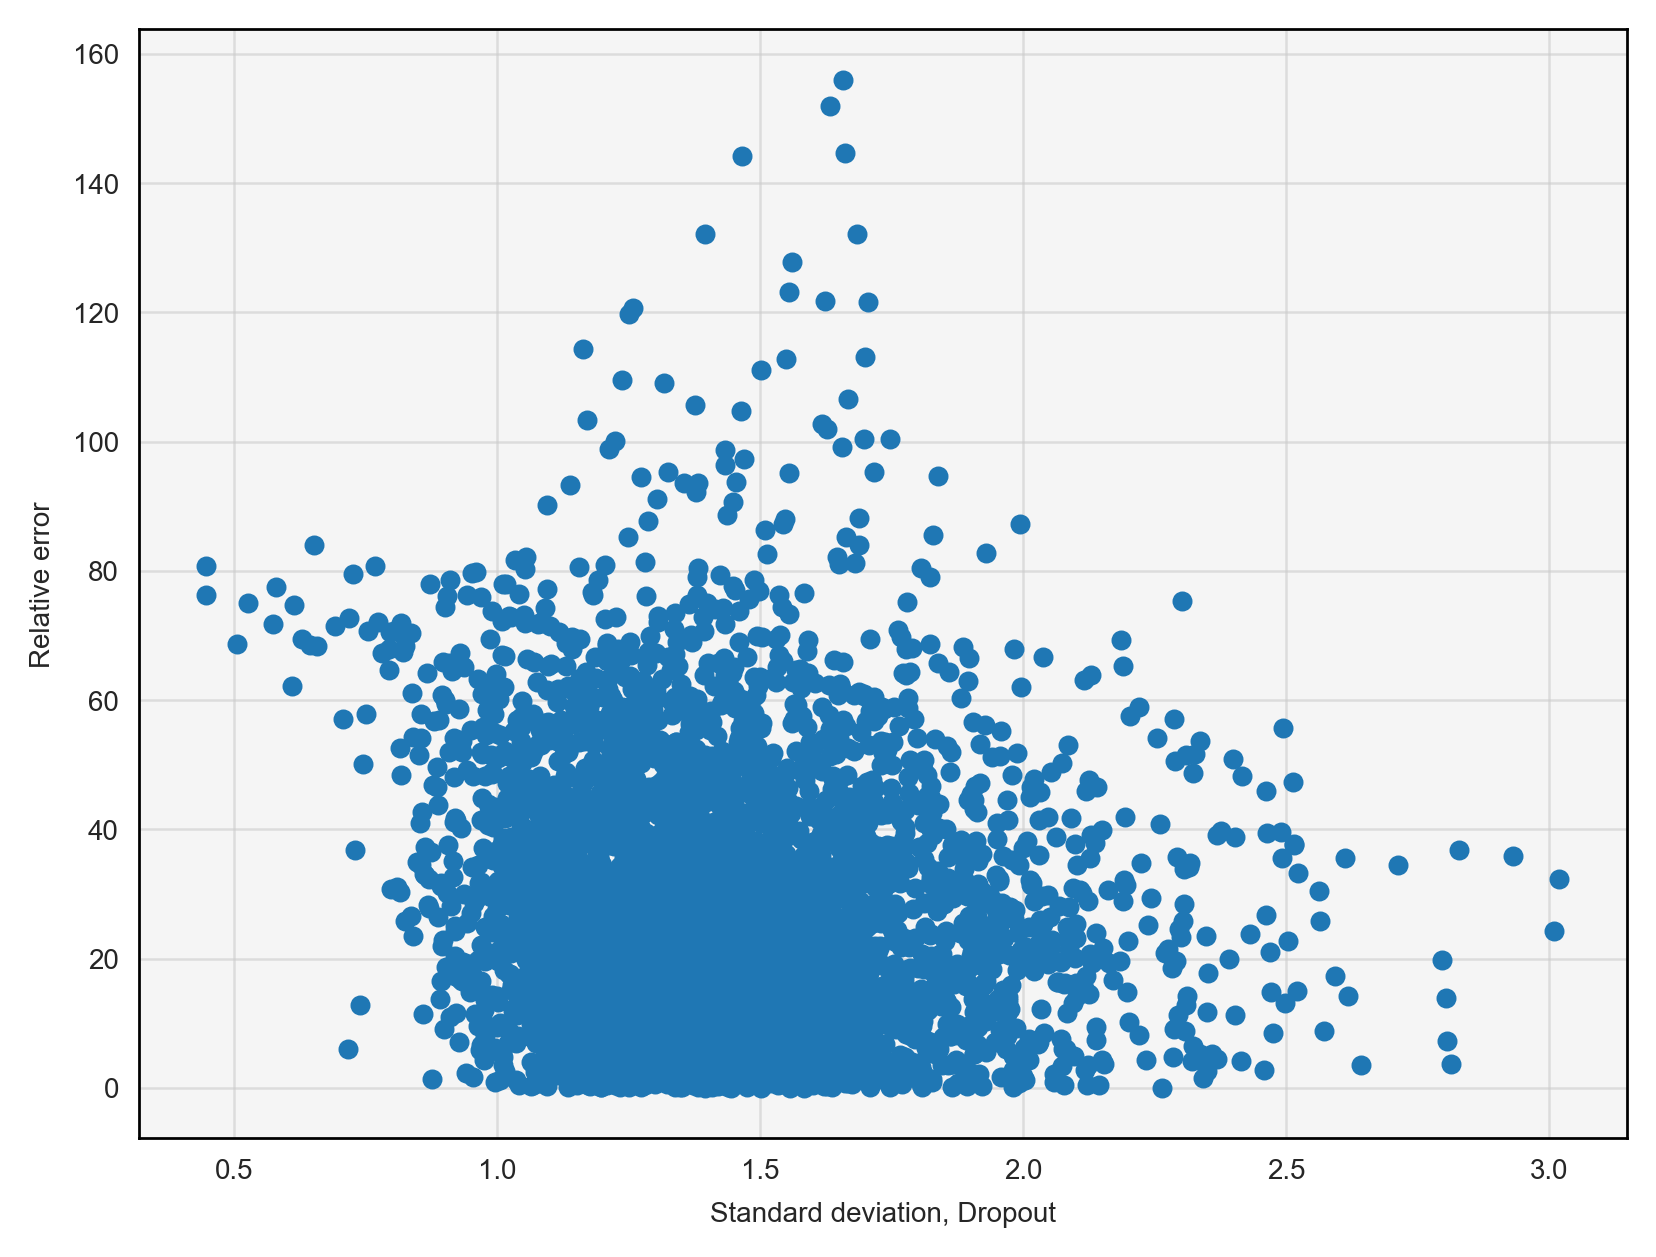

In [340]:
plt.scatter(np.squeeze(stds), metrics["mape"].numpy())
plt.xlabel("Standard deviation, Dropout")
plt.ylabel("Relative error")
plt.show()

##### Dropout à 0.5

In [321]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.5)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [322]:
predictions = []

for _ in range(50):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

 49/135 [=========>....................] - ETA: 0s

2024-01-15 18:26:25.716619: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_52/tf.nn.dropout_38/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


135/135 [==============================] - 1s 5ms/step


In [323]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [324]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.9905834
mape: 27.627441


In [325]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 3.9291296
mape: 26.809132


In [326]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[1.        , 0.01785866],
       [0.01785866, 1.        ]])

##### Dropout à 0.0

In [266]:
new_input = Input(shape=model.layers[1].input_shape[1:])
x = new_input

# Add layers from the nested model
for layer in model.get_layer("model_16").layers[1:]:  # Skipping its own input layer
    x = layer(x)
    if layer.name.startswith("dropout"):
        x = custom_dropout(x, 0.0)

# Add remaining layers from the main model
for layer in model.layers[2:]:  # Starting after the nested model
    x = layer(x)

# Create the new model
new_model = Model(inputs=new_input, outputs=x)

In [273]:
model.predict(data.x.eval)

135/135 [==============================] - 0s 3ms/step


array([[ 3.6927001],
       [12.490109 ],
       [ 7.881086 ],
       ...,
       [ 6.510739 ],
       [ 9.679227 ],
       [15.386527 ]], dtype=float32)

In [274]:
new_model.predict(data.x.eval)

135/135 [==============================] - 1s 4ms/step


array([[ 3.6927001],
       [12.490109 ],
       [ 7.881086 ],
       ...,
       [ 6.510739 ],
       [ 9.679227 ],
       [15.386527 ]], dtype=float32)

In [267]:
predictions = []

for _ in range(10):
    pred = new_model.predict(data.x.eval)
    predictions.append(pred)

predictions_array = np.array(predictions)

135/135 [==============================] - 1s 4ms/step


In [280]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [283]:
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.9291296
mape: 26.809132


In [284]:
inv_eval = model_eval.InversionModelEvaluation(
    pred=model.predict(data.x.eval), data=data
)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

135/135 [==============================] - 1s 4ms/step
mae: 3.9291296
mape: 26.809132


In [286]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.        , -0.08889776],
       [-0.08889776,  1.        ]])

#### Ensembling

In [135]:
dir_sweep = os.path.join(dir_res, "inv_oco3_32_sweep")
list_name_model = os.listdir(dir_sweep)
list_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in list_name_model
]

list_cfg = [None] * len(list_path_model)
for i, path_model in enumerate(list_path_model):
    list_cfg[i] = OmegaConf.load(os.path.join(path_model, "config.yaml"))
    list_cfg[i] = OmegaConf.to_container(list_cfg[i], resolve=True)

keys_with_diff_values = oco3_utils.check_diff_values(list_cfg)
print(keys_with_diff_values)

['data.input.chan_3', 'data.input.clouds_threshold', 'data.input.timedate', 'model.init.dropout_rate', 'model.dropout_rate', 'training.loss_func']


### All models

In [229]:
conditions = {
    "data.input.chan_3": "None",
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

ic| self.eval.shape: (39, 32, 32, 3)


In [190]:
inv_eval = model_eval.InversionModelEvaluation(data=data, dir_res=path_model)

2/2 [==============================] - 0s 4ms/step


In [231]:
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = pred_dict[name]

In [230]:
pred_dict = {}
mae_dict = {}
mape_dict = {}
pred = np.empty(shape=(data.y.eval.shape[0], len(filtered_path_model)))
for idx_model, name_model in enumerate(filtered_name_model):
    path_model = os.path.join(dir_sweep, name_model)
    inv_eval = model_eval.InversionModelEvaluation(data=data, dir_res=path_model)
    pred[:, idx_model] = np.squeeze(inv_eval.pred)
    pred_dict[name_model] = np.squeeze(inv_eval.pred)
    model_eval.print_inv_metrics(inv_eval.get_metrics(), message=path_model)
    mae_dict[name_model] = np.squeeze(np.median(inv_eval.results["mae"]))
    mape_dict[name_model] = np.squeeze(np.median(inv_eval.results["mape"]))

2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/19
MAE 10.545186 10.068958
MAPE 95.00796 51.923645
2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/8
MAE 7.3157387 5.8996315
MAPE 57.75258 32.946
2/2 [==============================] - 0s 6ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/29
MAE 7.2833266 6.2581635
MAPE 60.297832 32.29797
2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/30
MAE 7.3440976 7.3044496
MAPE 59.402805 33.902912
2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/4
MAE 7.016812 6.828287
MAPE 53.970158 31.899712
2/2 [==============================] - 0s 3ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/21
MAE 7.0630283 5.8409767
MAPE 53.534943 31.245167
2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/in

In [200]:
mean_pred = np.sum(pred, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(mae_dict.values())))
print("Mean MAPEs", np.mean(list(mape_dict.values())))


Ensemble
MAE 9.542220945939677 11.360762418797
MAPE 73.4308275670225 44.19809682300556
Mean MAEs 6.810378
Mean MAPEs 35.12314


### "data.input.timedate": True

In [166]:
conditions = {"data.input.chan_3": "None", "data.input.timedate": True}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

ic| len(filtered_path_model): 16
ic| self.eval.shape: (39, 32, 32, 3)


In [167]:
pred = np.empty(shape=(data.y.eval.shape[0], len(filtered_path_model)))
for idx_model, path_model in enumerate(filtered_path_model):
    inv_eval = model_eval.InversionModelEvaluation(data=data, dir_res=path_model)
    pred[:, idx_model] = np.squeeze(inv_eval.pred)

    model_eval.print_inv_metrics(inv_eval.get_metrics(), message=path_model)

2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/19
MAE 10.545186 10.068958
MAPE 95.00796 51.923645
2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/30
MAE 7.3440976 7.3044496
MAPE 59.402805 33.902912
2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/31
MAE 6.9725184 6.740307
MAPE 56.82756 29.820868
2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/6
MAE 6.8815613 5.4097176
MAPE 53.521427 30.506334
2/2 [==============================] - 0s 3ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/27
MAE 7.0892444 7.5779705
MAPE 54.56003 32.222385
2/2 [==============================] - 0s 3ms/step
/libre/dumontj/coco2/weights/new/inv_oco3_32_sweep/18
MAE 10.277197 9.627844
MAPE 90.54455 45.970276
2/2 [==============================] - 0s 4ms/step
/libre/dumontj/coco2/weights/new

In [168]:
mean_pred = np.sum(pred, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")



Ensemble
MAE 10.001794227550171 4.368791191623761
MAPE 47.950740729474745 37.91737754678353


In [211]:
conditions = {"data.input.chan_3": "None", "data.input.timedate": True}

filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

filtered_pred_dict = {
    name: pred_dict[name] for name in filtered_name_model if name in pred_dict
}
filtered_mae_dict = {
    name: mae_dict[name] for name in filtered_name_model if name in mae_dict
}
filtered_mape_dict = {
    name: mape_dict[name] for name in filtered_name_model if name in mape_dict
}

num_obs = len(next(iter(filtered_pred_dict.values())))
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = filtered_pred_dict[name]


mean_pred = np.sum(pred_array, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(filtered_mae_dict.values())))
print("Mean MAPEs", np.mean(list(filtered_mape_dict.values())))

ic| len(filtered_path_model): 16
ic| self.eval.shape: (39, 32, 32, 3)



Ensemble
MAE 10.001794227550171 4.368791191623761
MAPE 47.950740729474745 37.91737754678353
Mean MAEs 6.6868353
Mean MAPEs 34.44799


### training loss func

In [213]:
conditions = {
    "data.input.chan_3": "None",
    "data.input.timedate": True,
    "training.loss_func": "MeanSquaredError",
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

filtered_pred_dict = {
    name: pred_dict[name] for name in filtered_name_model if name in pred_dict
}
filtered_mae_dict = {
    name: mae_dict[name] for name in filtered_name_model if name in mae_dict
}
filtered_mape_dict = {
    name: mape_dict[name] for name in filtered_name_model if name in mape_dict
}

num_obs = len(next(iter(filtered_pred_dict.values())))
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = filtered_pred_dict[name]


mean_pred = np.sum(pred_array, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(filtered_mae_dict.values())))
print("Mean MAPEs", np.mean(list(filtered_mape_dict.values())))

ic| len(filtered_path_model): 8
ic| self.eval.shape: (39, 32, 32, 3)



Ensemble
MAE 13.29307610878107 8.85426213649603
MAPE 63.878802461269174 65.10486682456377
Mean MAEs 6.105565
Mean MAPEs 32.461075


In [214]:
conditions = {
    "data.input.chan_3": "None",
    "data.input.timedate": True,
    "training.loss_func": "MeanAbsoluteError",
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

filtered_pred_dict = {
    name: pred_dict[name] for name in filtered_name_model if name in pred_dict
}
filtered_mae_dict = {
    name: mae_dict[name] for name in filtered_name_model if name in mae_dict
}
filtered_mape_dict = {
    name: mape_dict[name] for name in filtered_name_model if name in mape_dict
}

num_obs = len(next(iter(filtered_pred_dict.values())))
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = filtered_pred_dict[name]


mean_pred = np.sum(pred_array, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(filtered_mae_dict.values())))
print("Mean MAPEs", np.mean(list(filtered_mape_dict.values())))

ic| len(filtered_path_model): 8
ic| self.eval.shape: (39, 32, 32, 3)



Ensemble
MAE 13.485224199061877 9.055074081589014
MAPE 65.27356705559333 66.58142520294878
Mean MAEs 7.2681055
Mean MAPEs 36.43491


### data.input.clouds_threshold

In [215]:
conditions = {
    "data.input.chan_3": "None",
    "data.input.timedate": True,
    "data.input.clouds_threshold": 0.25,
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

filtered_pred_dict = {
    name: pred_dict[name] for name in filtered_name_model if name in pred_dict
}
filtered_mae_dict = {
    name: mae_dict[name] for name in filtered_name_model if name in mae_dict
}
filtered_mape_dict = {
    name: mape_dict[name] for name in filtered_name_model if name in mape_dict
}

num_obs = len(next(iter(filtered_pred_dict.values())))
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = filtered_pred_dict[name]


mean_pred = np.sum(pred_array, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(filtered_mae_dict.values())))
print("Mean MAPEs", np.mean(list(filtered_mape_dict.values())))

ic| len(filtered_path_model): 4
ic| self.eval.shape: (39, 32, 32, 3)



Ensemble
MAE 15.768977984403959 11.377004085442959
MAPE 82.64924559814634 83.6544394582838
Mean MAEs 6.4384327
Mean MAPEs 31.259848


In [216]:
conditions = {
    "data.input.chan_3": "None",
    "data.input.timedate": True,
    "data.input.clouds_threshold": 0.5,
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

filtered_pred_dict = {
    name: pred_dict[name] for name in filtered_name_model if name in pred_dict
}
filtered_mae_dict = {
    name: mae_dict[name] for name in filtered_name_model if name in mae_dict
}
filtered_mape_dict = {
    name: mape_dict[name] for name in filtered_name_model if name in mape_dict
}

num_obs = len(next(iter(filtered_pred_dict.values())))
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = filtered_pred_dict[name]


mean_pred = np.sum(pred_array, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(filtered_mae_dict.values())))
print("Mean MAPEs", np.mean(list(filtered_mape_dict.values())))

ic| len(filtered_path_model): 4
ic| self.eval.shape: (39, 32, 32, 3)



Ensemble
MAE 15.827740395298369 11.435766496337378
MAPE 83.10789330768692 84.08651599685865
Mean MAEs 5.76412
Mean MAPEs 31.298048


In [218]:
conditions = {
    "data.input.chan_3": "None",
    "data.input.timedate": True,
    "data.input.clouds_threshold": 0.74,
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

filtered_pred_dict = {
    name: pred_dict[name] for name in filtered_name_model if name in pred_dict
}
filtered_mae_dict = {
    name: mae_dict[name] for name in filtered_name_model if name in mae_dict
}
filtered_mape_dict = {
    name: mape_dict[name] for name in filtered_name_model if name in mape_dict
}

num_obs = len(next(iter(filtered_pred_dict.values())))
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = filtered_pred_dict[name]


mean_pred = np.sum(pred_array, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(filtered_mae_dict.values())))
print("Mean MAPEs", np.mean(list(filtered_mape_dict.values())))

ic| len(filtered_path_model): 4
ic| self.eval.shape: (39, 32, 32, 3)



Ensemble
MAE 15.924360502224705 11.532386603263708
MAPE 83.86202490410746 84.79695793962489
Mean MAEs 5.4069815
Mean MAPEs 29.89165


In [219]:
conditions = {
    "data.input.chan_3": "None",
    "data.input.timedate": True,
    "data.input.clouds_threshold": 0.99,
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

filtered_pred_dict = {
    name: pred_dict[name] for name in filtered_name_model if name in pred_dict
}
filtered_mae_dict = {
    name: mae_dict[name] for name in filtered_name_model if name in mae_dict
}
filtered_mape_dict = {
    name: mape_dict[name] for name in filtered_name_model if name in mape_dict
}

num_obs = len(next(iter(filtered_pred_dict.values())))
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = filtered_pred_dict[name]


mean_pred = np.sum(pred_array, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(filtered_mae_dict.values())))
print("Mean MAPEs", np.mean(list(filtered_mape_dict.values())))

ic| len(filtered_path_model): 4
ic| self.eval.shape: (39, 32, 32, 3)



Ensemble
MAE 15.156153694941448 10.764179795980453
MAPE 77.86607805218192 79.14837863274522
Mean MAEs 9.137807
Mean MAPEs 45.342422


### Study of nice sub-ensemble

In [356]:
conditions = {
    "data.input.chan_3": "None",
    "data.input.timedate": True,
    "data.input.clouds_threshold": 0.74,
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]
ic(len(filtered_path_model))
data = model_eval.get_data_for_inversion(filtered_path_model[0], path_extra_valid_nc)

filtered_pred_dict = {
    name: pred_dict[name] for name in filtered_name_model if name in pred_dict
}
filtered_mae_dict = {
    name: mae_dict[name] for name in filtered_name_model if name in mae_dict
}
filtered_mape_dict = {
    name: mape_dict[name] for name in filtered_name_model if name in mape_dict
}

num_obs = len(next(iter(filtered_pred_dict.values())))
pred_array = np.empty((num_predictions, len(filtered_name_model)))
for idx, name in enumerate(filtered_name_model):
    pred_array[:, idx] = filtered_pred_dict[name]


mean_pred = np.sum(pred_array, axis=1) / len(list_paths_model)
ensemble_model_eval = model_eval.InversionModelEvaluation(data=data, pred=mean_pred)
metrics = ensemble_model_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\nEnsemble")

print("Mean MAEs", np.mean(list(filtered_mae_dict.values())))
print("Mean MAPEs", np.mean(list(filtered_mape_dict.values())))

ic| len(filtered_path_model): 4
ic| self.eval.shape: (39, 32, 32, 3)



Ensemble
MAE 15.924360502224705 11.532386603263708
MAPE 83.86202490410746 84.79695793962489
Mean MAEs 5.4069815
Mean MAPEs 29.89165


In [222]:
print(np.c_[pred_array, inv_eval.y])

[[15.13088894 17.48641396 12.75833321 12.9257946  13.60000038]
 [18.54003906 14.69842148 16.27207565 14.06768513 13.60000038]
 [12.63539696 13.24395466 13.3290472  13.15392017 13.60000038]
 [11.3500576  10.62264538  9.22137928  9.95172215 13.60000038]
 [27.18167305 26.0216713  28.9888916  24.93566513 37.59999847]
 [23.38952255 20.58316994 25.13154602 22.45240974 37.59999847]
 [26.12961769 25.76582336 31.84589005 25.69794273 37.59999847]
 [24.20689011 23.42587662 20.25148582 25.87939072 37.59999847]
 [22.27898407 20.31690216 23.01178932 21.37010193 30.        ]
 [18.13261795 20.64445305 18.6900692  16.83443832 30.        ]
 [23.3734684  17.75864983 18.78120422 16.31186295 30.        ]
 [19.18845177 19.45536041 23.97780991 20.45102692 30.        ]
 [18.56189728 16.63900948 17.23354721 18.34244156 30.        ]
 [22.14566422 24.78277969 26.03295326 23.37763405 30.        ]
 [15.99015903 14.81906414 18.28264999 15.92950439 30.        ]
 [25.38062286 20.98150444 25.36436844 21.0044136  30.  

### AUTRE

In [375]:
predictions = []

for path_model in list_paths_model:
    if not data_similar:
        data = get_data_for_inversion(path_model, path_ds_nc)
    model_eval = InversionModelEvaluation(data=data, dir_res=path_model)
    current_pred = tf.convert_to_tensor(model_eval.pred, np.float32)
    predictions.append(current_pred)

    print_inv_metrics(model_eval.get_metrics(), message=path_model)

# Convert list of predictions to a tensor or numpy array
predictions_array = tf.stack(predictions).numpy()

ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/4
MAE 3.8103805 3.2514427
MAPE 25.828455 21.735388


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/5
MAE 3.8344004 3.271966
MAPE 25.776129 22.17398


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/6
MAE 3.838899 3.2899017
MAPE 26.084942 22.021507


ic| self.eval.shape: (4296, 32, 32, 3)


135/135 [==============================] - 1s 4ms/step
/libre/dumontj/coco2/weights/new/inv_lip_test_32_sweep/7
MAE 3.6728024 3.089128
MAPE 24.74554 20.67641


In [377]:
predictions_array = predictions_array.numpy()

In [380]:
means = np.mean(predictions_array, axis=0)
stds = np.std(predictions_array, axis=0)

In [382]:
inv_eval = InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

mae: 3.6636415
mape: 24.73811


In [384]:
np.corrcoef(np.squeeze(stds), metrics["mape"].numpy())

array([[ 1.        , -0.02669349],
       [-0.02669349,  1.        ]])

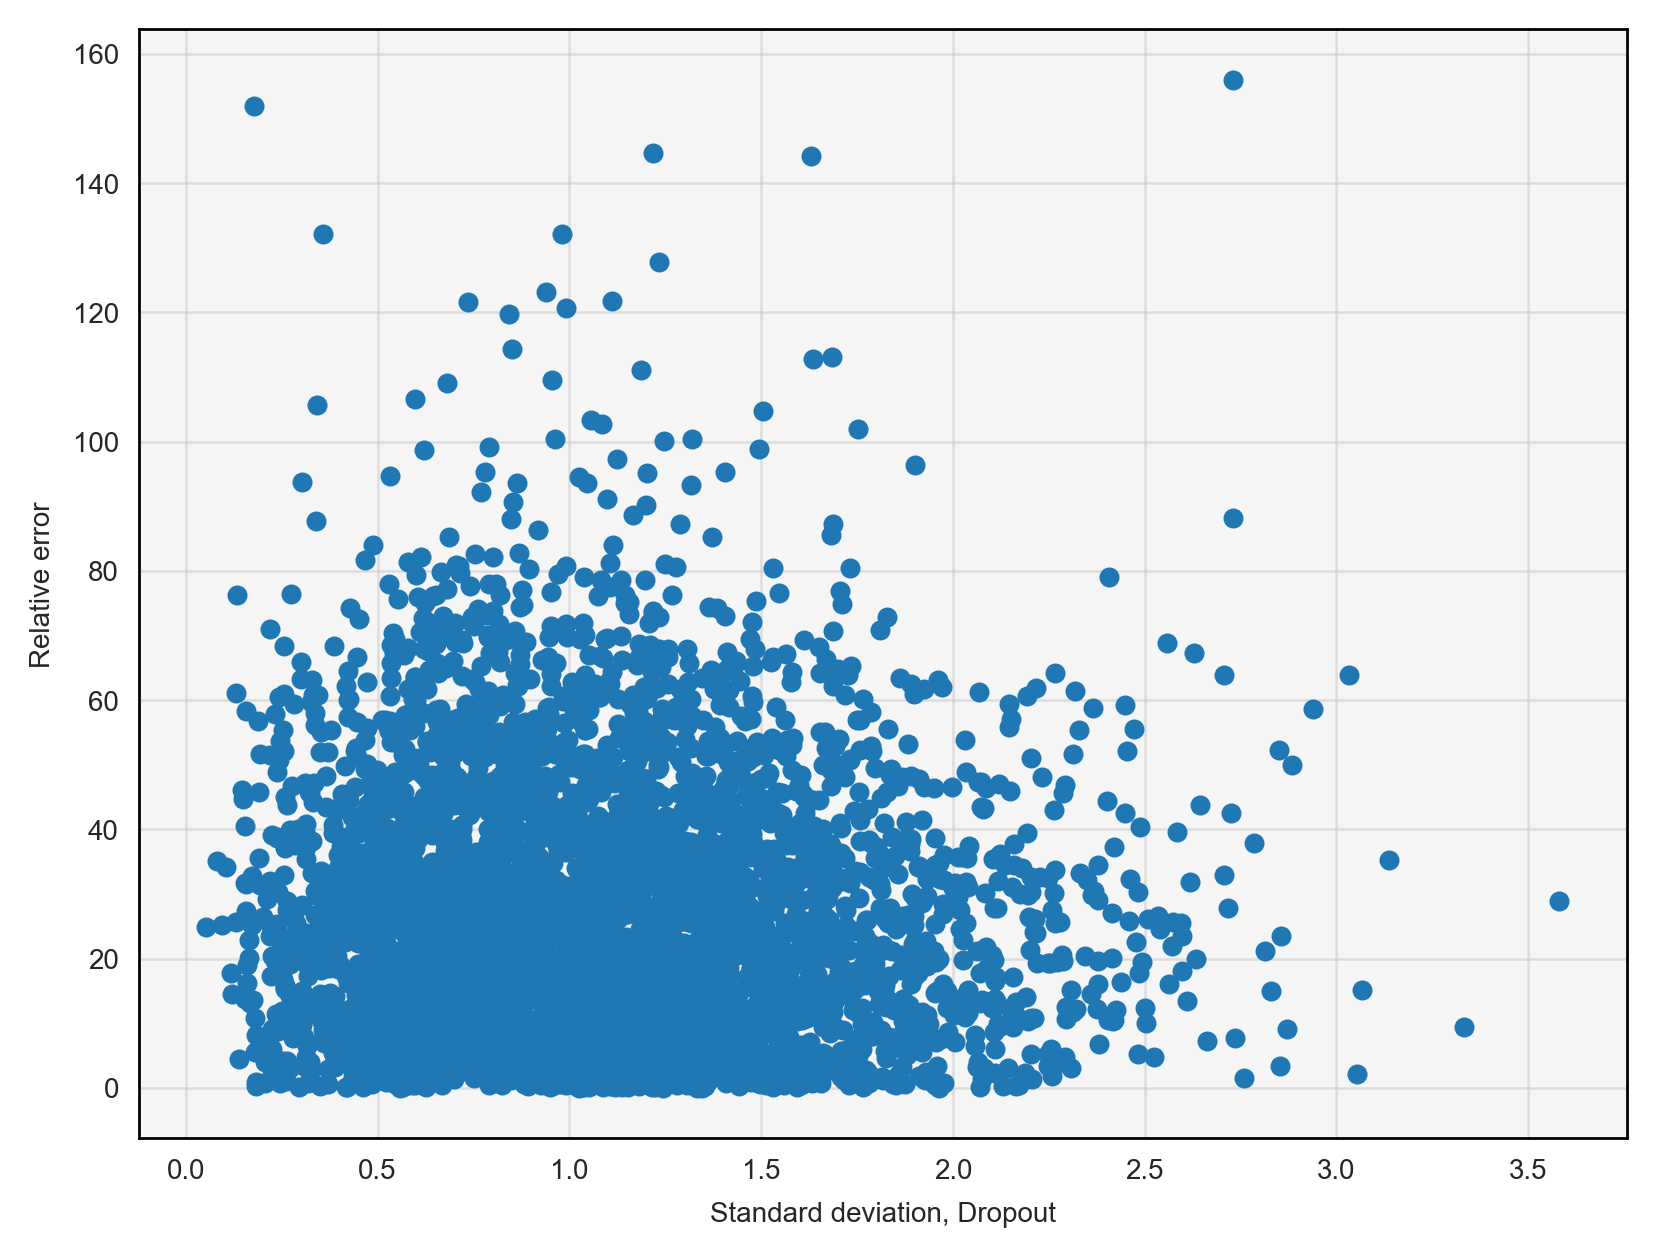

In [386]:
plt.scatter(np.squeeze(stds), metrics["mape"].numpy())
plt.xlabel("Standard deviation, Dropout")
plt.ylabel("Relative error")
plt.show()

### Gaussian layer only

In [352]:
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
mape = tf.keras.losses.MeanAbsolutePercentageError(
    reduction=tf.keras.losses.Reduction.NONE
)

In [445]:
def compute_noisy_predictions(
    model: tf.keras.models.Model, x: np.ndarray, n_pred: int, noise_level: int
):
    noisy_predictions = []
    with Progress() as progress:
        task = progress.add_task("[green]Processing noisy predictions", total=n_pred)
        for _ in range(n_pred):
            noise = np.random.normal(0, noise_level, x.shape)
            noisy_data = x + noise
            predictions = model.predict(noisy_data, verbose=0)
            noisy_predictions.append(predictions)
            progress.update(task, advance=1)
        noisy_predictions = np.array(noisy_predictions)

    return noisy_predictions


def compute_noisy_stats(noisy_predictions: np.ndarray, y: np.ndarray):
    noisy_mae = []
    noisy_mape = []
    for prediction in noisy_predictions:
        noisy_mae.append(mae(y, prediction))
        noisy_mape.append(mape(y, prediction))
    noisy_mae = np.array(noisy_mae)
    noisy_mape = np.array(noisy_mape)
    stds_mae = np.std(
        noisy_predictions, axis=0
    )  # because it would not be relative if not

    means = np.mean(noisy_predictions, axis=0)
    stds_mape = (
        np.std(noisy_predictions, axis=0) / means
    )  # because it would not be relative if not
    return means, stds_mae, stds_mape


def compute_corrcoef_noisystd_error(model, data, n_pred=10, noise_level=0.1):
    inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
    metrics = inv_eval.get_metrics()
    noisy_predictions = compute_noisy_predictions(
        model, data.x.eval, n_pred, noise_level
    )
    means, stds = compute_noisy_stats(noisy_predictions, data.y.eval)

    return np.corrcoef(np.squeeze(stds), metrics["mae"].numpy())[0, 1]


def compute_corr_for_range_noises(
    model, data, n_pred, noise_levels=[0.2, 0.22, 0.25, 0.3]
):
    inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
    metrics = inv_eval.get_metrics()
    all_corrcoefs_mae = []
    all_corrcoefs_mape = []
    all_stds_mae = []
    all_stds_mape = []

    for noise_level in noise_levels:
        ic(noise_level)
        noisy_predictions = compute_noisy_predictions(
            model, data.x.eval, n_pred, noise_level
        )
        means, stds_mae, stds_mape = compute_noisy_stats(noisy_predictions, data.y.eval)
        all_corrcoefs_mae.append(
            np.corrcoef(np.squeeze(stds_mae), metrics["mae"].numpy())[0, 1]
        )
        all_stds_mae.append(stds_mae)
        all_corrcoefs_mape.append(
            np.corrcoef(np.squeeze(stds_mape), metrics["mae"].numpy())[0, 1]
        )
        all_stds_mape.append(stds_mape)

    return all_corrcoefs_mae, all_corrcoefs_mape, all_stds_mae, all_stds_mape

In [446]:
(
    all_corrcoefs_mae,
    all_corrcoefs_mape,
    all_stds_mae,
    all_stds_mape,
) = compute_corr_for_range_noises(model, data, 100)

2/2 [==============================] - 0s 5ms/step


ic| noise_level: 0.2


Output()

ic| noise_level: 0.22


Output()

ic| noise_level: 0.25


Output()

ic| noise_level: 0.3


Output()

In [447]:
print(np.c_[all_corrcoefs_mae, all_corrcoefs_mape])

[[-0.2595525  -0.47490768]
 [-0.29589618 -0.5099952 ]
 [-0.2537391  -0.48729582]
 [-0.22094244 -0.4908743 ]]


2/2 [==============================] - 0s 4ms/step


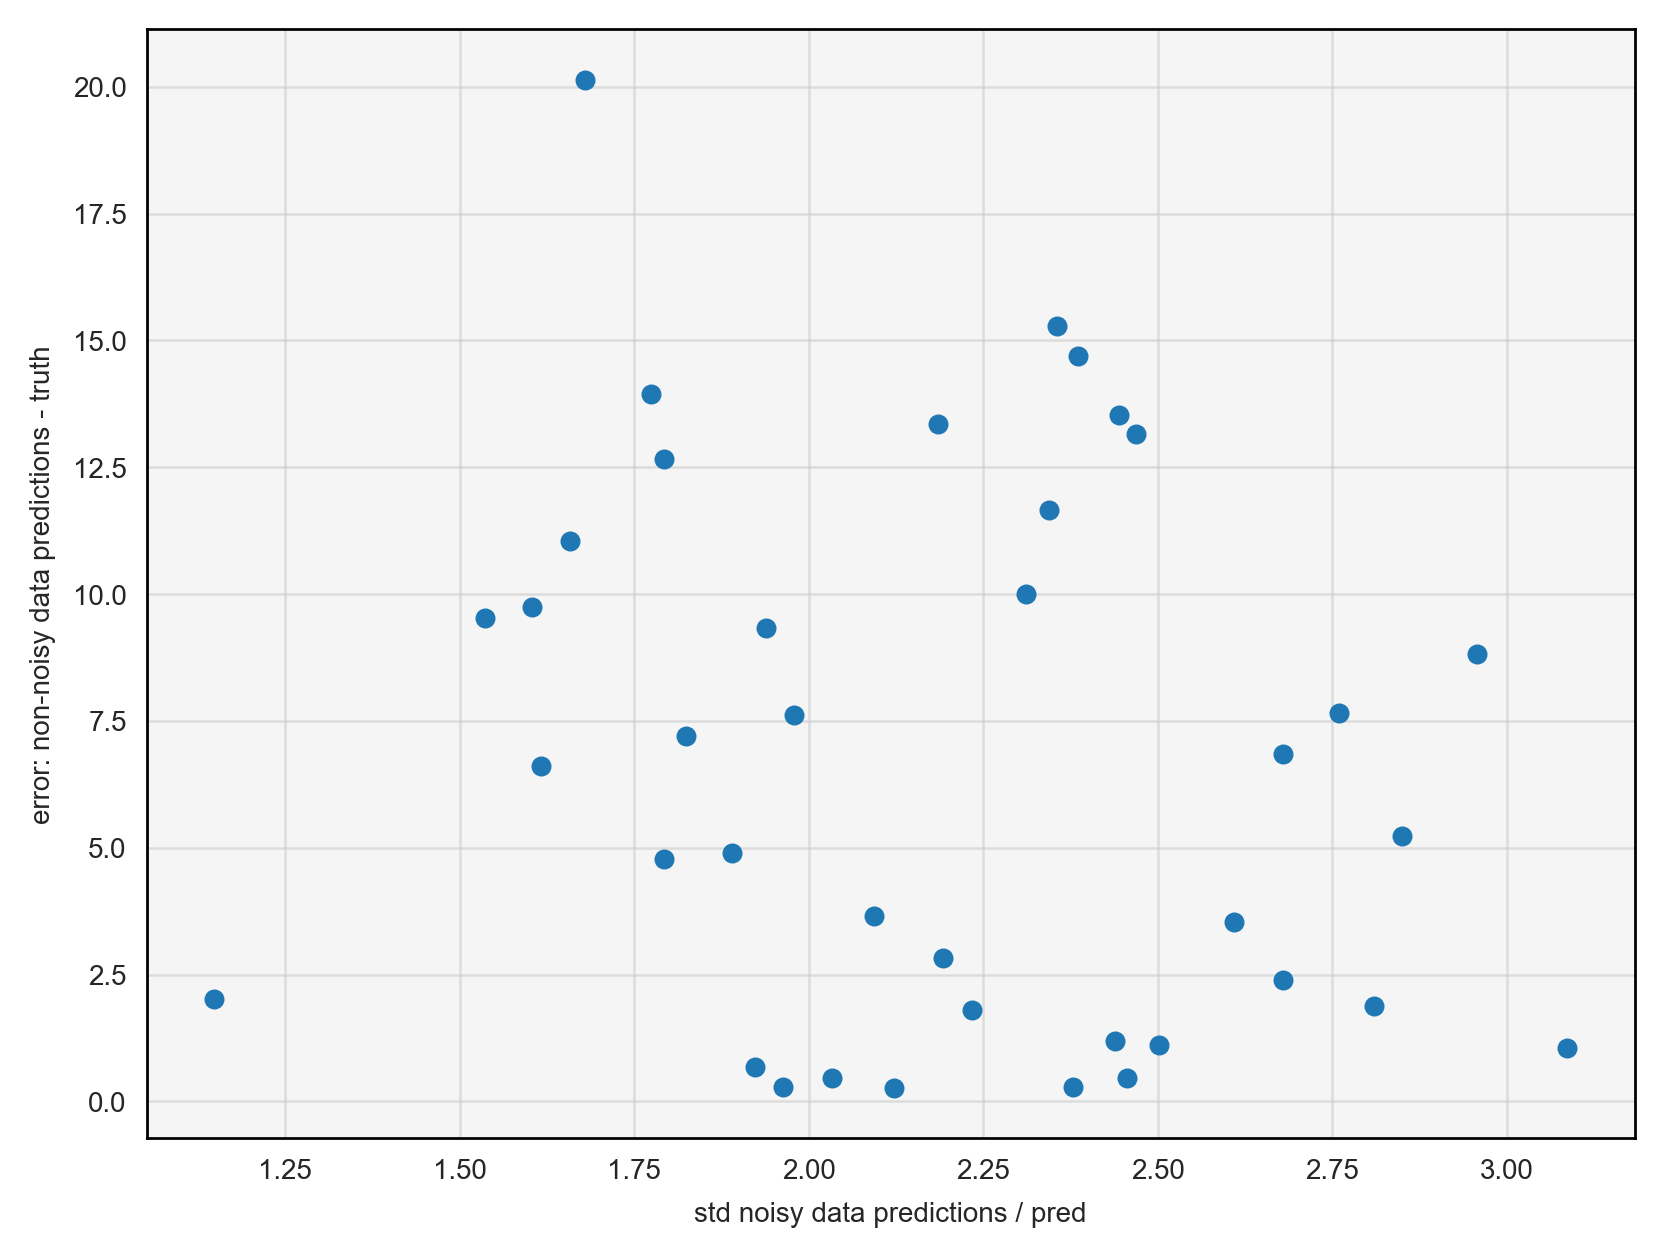

In [442]:
inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval.get_metrics()
plt.scatter(np.squeeze(all_stds[2]), metrics["mae"].numpy())
plt.xlabel("std noisy data predictions / pred")
plt.ylabel("error: non-noisy data predictions - truth")
plt.show()

In [359]:
inv_eval_ref = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval_ref.get_metrics()
model_eval.print_inv_metrics(metrics, message="\Reference")

2/2 [==============================] - 0s 5ms/step
\Reference
MAE 6.8789244 5.4097176
MAPE 52.669346 29.903137


In [361]:
noisy_predictions = compute_noisy_predictions(model, data.x.eval, 100, 0.3)
means, stds_mae, stds_mape = compute_noisy_stats(noisy_predictions, data.y.eval)
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\Means")

Output()

\Means
MAE 6.7638345 7.2678246
MAPE 53.831886 30.116093


In [364]:
print(np.c_[inv_eval_ref.pred, inv_eval.y, inv_eval.pred, stds_mae])

[[15.13088894 13.60000038 16.48464775  2.01496267]
 [18.54003906 13.60000038 18.08969879  2.05264783]
 [12.62795544 13.60000038 14.86965847  1.62333715]
 [11.3500576  13.60000038 11.71632576  1.69595623]
 [27.18167305 37.59999847 25.25482178  2.32518315]
 [23.80745697 37.59999847 22.34976006  2.59710455]
 [26.35641861 37.59999847 24.83760071  2.07928586]
 [26.34105492 37.59999847 27.00688553  1.62249255]
 [21.56840515 30.         20.36318398  2.48898602]
 [18.13261795 30.         18.5598278   2.72243023]
 [21.69215202 30.         22.49864197  2.08136487]
 [19.23577881 30.         20.96517181  1.6878742 ]
 [18.56196976 30.         19.98477173  2.42003417]
 [22.11866188 30.         23.16583252  1.67158413]
 [15.39509487 30.         16.03489685  2.79567385]
 [24.75141335 30.         24.68053436  2.06000566]
 [12.02042961 12.37349987 15.49422359  2.70886326]
 [14.57722759 12.37349987 13.96510696  1.73336482]
 [10.85733986 12.37349987 11.48719692  1.64871037]
 [ 9.55528259 14.96500015 15.56

### Several models + Gaussian layer

In [405]:
conditions = {
    "data.input.chan_3": "None",
    "data.input.timedate": True,
    "data.input.clouds_threshold": 0.74,
}
filtered_name_model = oco3_utils.filter_name_models(
    list_name_model, conditions, dir_sweep
)
filtered_path_model = [
    os.path.join(dir_sweep, name_model) for name_model in filtered_name_model
]

In [404]:
def compute_corr_for_range_noises_models(
    list_path_model,
    data,
    n_pred,
    noise_levels=[0.2, 0.22, 0.25, 0.3, 0.35, 0.4],
):
    model = model_eval.get_inversion_model(list_path_model[0], name_w="w_last.h5")
    inv_eval = model_eval.InversionModelEvaluation(model=model, data=data)
    metrics = inv_eval.get_metrics()
    all_corrcoefs_mae = []
    all_corrcoefs_mape = []
    all_stds_mae = []
    all_stds_mape = []

    for noise_level in noise_levels:
        ic(noise_level)
        noisy_predictions = []
        for idx_model, path_model in enumerate(list_path_model):
            model = model_eval.get_inversion_model(path_model, name_w="w_last.h5")
            noisy_predictions.append(
                compute_noisy_predictions(model, data.x.eval, n_pred, noise_level)
            )
        noisy_predictions = np.array(noisy_predictions)
        means, stds_mae, stds_mape = compute_noisy_stats(noisy_predictions, data.y.eval)
        all_corrcoefs_mae.append(
            np.corrcoef(np.squeeze(stds_mae), metrics["mae"].numpy())[0, 1]
        )
        all_stds_mae.append(stds_mae)
        all_corrcoefs_mape.append(
            np.corrcoef(np.squeeze(stds_mape), metrics["mae"].numpy())[0, 1]
        )
        all_stds_mape.append(stds_mape)

    return all_corrcoefs_mae, all_corrcoefs_mape, all_stds_mae, all_stds_mape

In [410]:
(
    all_corrcoefs_mae,
    all_corrcoefs_mape,
    all_stds_mae,
    all_stds_mape,
) = compute_corr_for_range_noises_models(filtered_path_model, data, 100)

2/2 [==============================] - 0s 6ms/step


ic| noise_level: 0.2


Output()

Output()

Output()

Output()

ic| noise_level: 0.22


Output()

Output()

Output()

Output()

ic| noise_level: 0.25


Output()

Output()

Output()

Output()

ic| noise_level: 0.3


Output()

Output()

Output()

Output()

ic| noise_level: 0.35


Output()

Output()

Output()

Output()

ic| noise_level: 0.4


Output()

Output()

Output()

Output()

In [414]:
all_corrcoefs_mae

[0.08153909472788481,
 0.330068189700912,
 0.14051533979185907,
 0.22960547052437977,
 0.4233741521531023,
 0.38765279261899266]

In [450]:
inv_eval_ref = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval_ref.get_metrics()
model_eval.print_inv_metrics(metrics, message="\Reference")

2/2 [==============================] - 0s 4ms/step
\Reference
MAE 6.7085705 6.6036606
MAPE 46.885723 32.45927


In [451]:
noisy_predictions = []
for idx_model, path_model in enumerate(list_path_model):
    model = model_eval.get_inversion_model(path_model, name_w="w_last.h5")
    noisy_predictions.append(compute_noisy_predictions(model, data.x.eval, 100, 0.22))
noisy_predictions = np.concatenate(noisy_predictions, axis=0)

means, stds_mae, stds_mape = compute_noisy_stats(noisy_predictions, data.y.eval)
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\Means")

Output()

Output()

Output()

Output()

\Means
MAE 6.521749 5.554813
MAPE 50.050934 28.208961


In [452]:
print(np.c_[inv_eval_ref.pred, inv_eval.y, means])

[[12.9257946  13.60000038 15.34214497]
 [14.06768513 13.60000038 16.85670471]
 [13.13516998 13.60000038 13.03349686]
 [ 9.95172215 13.60000038 10.06528854]
 [24.93566513 37.59999847 26.66596603]
 [22.312006   37.59999847 22.88710403]
 [29.97849655 37.59999847 28.17623329]
 [26.55845642 37.59999847 26.1542778 ]
 [20.00750732 30.         20.35907555]
 [16.83443832 30.         18.96907425]
 [16.64750671 30.         20.14418983]
 [20.47001648 30.         21.53731155]
 [18.342453   30.         18.94734192]
 [23.39633942 30.         24.39837456]
 [15.30069447 30.         15.68830204]
 [20.26221848 30.         23.07001877]
 [10.49668121 12.37349987 13.89517784]
 [12.65332985 12.37349987 13.46452522]
 [ 8.84184551 12.37349987 10.08142471]
 [ 9.73241138 14.96500015 12.98925686]
 [13.84629726 14.96500015 13.03291607]
 [13.9057703  14.96500015 14.15717793]
 [14.69847107 14.96500015 20.01548004]
 [ 8.12169838 14.96500015 12.24244881]
 [ 6.1498065  14.96500015 12.33632278]
 [ 5.31707573  5.03700018

In [453]:
noisy_predictions = []
for idx_model, path_model in enumerate(list_path_model):
    model = model_eval.get_inversion_model(path_model, name_w="w_last.h5")
    noisy_predictions.append(compute_noisy_predictions(model, data.x.eval, 100, 0.25))
noisy_predictions = np.concatenate(noisy_predictions, axis=0)

means, stds_mae, stds_mape = compute_noisy_stats(noisy_predictions, data.y.eval)
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\Means")

Output()

Output()

Output()

Output()

\Means
MAE 6.476676 5.652973
MAPE 50.625607 26.322634


In [454]:
noisy_predictions = []
for idx_model, path_model in enumerate(list_path_model):
    model = model_eval.get_inversion_model(path_model, name_w="w_last.h5")
    noisy_predictions.append(compute_noisy_predictions(model, data.x.eval, 100, 0.3))
noisy_predictions = np.concatenate(noisy_predictions, axis=0)

means, stds_mae, stds_mape = compute_noisy_stats(noisy_predictions, data.y.eval)
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\Means")

Output()

Output()

Output()

Output()

\Means
MAE 6.5395145 6.375704
MAPE 53.098427 28.440964


In [455]:
noisy_predictions = []
for idx_model, path_model in enumerate(list_path_model):
    model = model_eval.get_inversion_model(path_model, name_w="w_last.h5")
    noisy_predictions.append(compute_noisy_predictions(model, data.x.eval, 500, 0.22))
noisy_predictions = np.concatenate(noisy_predictions, axis=0)

means, stds_mae, stds_mape = compute_noisy_stats(noisy_predictions, data.y.eval)
inv_eval = model_eval.InversionModelEvaluation(pred=means, data=data)
metrics = inv_eval.get_metrics()
model_eval.print_inv_metrics(metrics, message="\Means")

Output()

Output()

Output()

Output()

\Means
MAE 6.5259933 5.443878
MAPE 50.262363 27.447594


In [449]:
inv_eval_ref = model_eval.InversionModelEvaluation(model=model, data=data)
metrics = inv_eval_ref.get_metrics()
model_eval.print_inv_metrics(metrics, message="\Reference")

2/2 [==============================] - 0s 4ms/step
\Reference
MAE 6.7085705 6.6036606
MAPE 46.885723 32.45927


### Study of the worst image

In [467]:
ic(data.y.eval[32], inv_eval_ref.model.predict(data.x.eval[32:33]))

1/1 [==============================] - 0s 18ms/step


ic| data.y.eval[32]: array([7.19049978])
    inv_eval_ref.model.predict(data.x.eval[32:33]): array([[27.329348]], dtype=float32)


(array([7.19049978]), array([[27.329348]], dtype=float32))

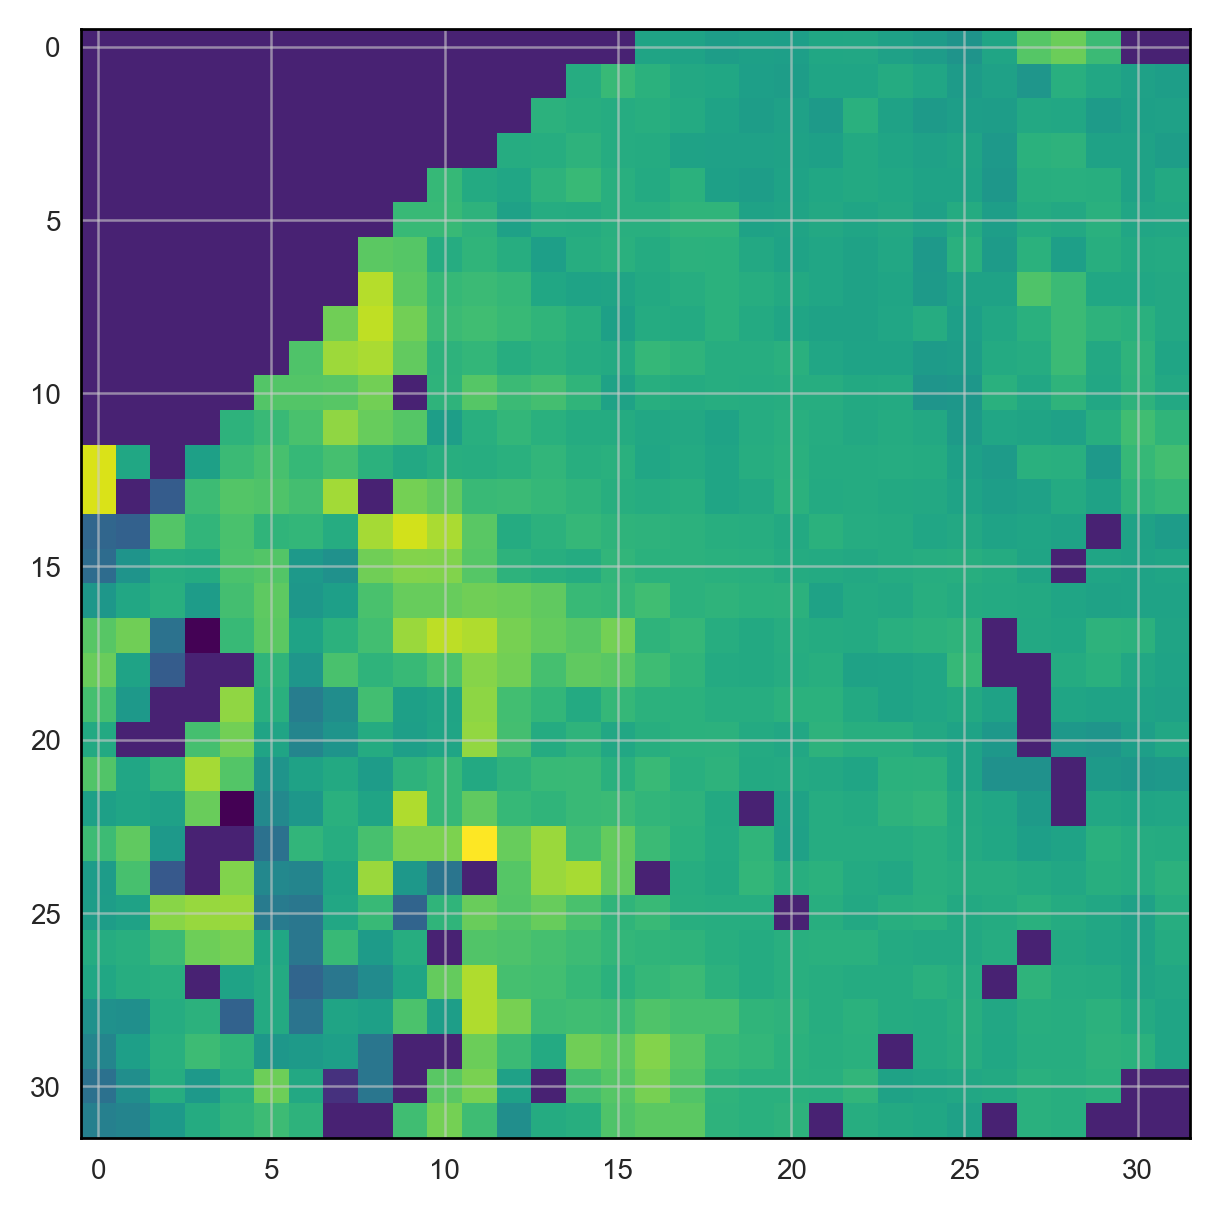

In [465]:
plt.imshow(data.x.eval[32][..., 0])

In [470]:
ic(data.y.eval[31], inv_eval_ref.model.predict(data.x.eval[31:32]))

1/1 [==============================] - 0s 20ms/step


ic| data.y.eval[31]: array([7.19049978])
    inv_eval_ref.model.predict(data.x.eval[31:32]): array([[21.137405]], dtype=float32)


(array([7.19049978]), array([[21.137405]], dtype=float32))

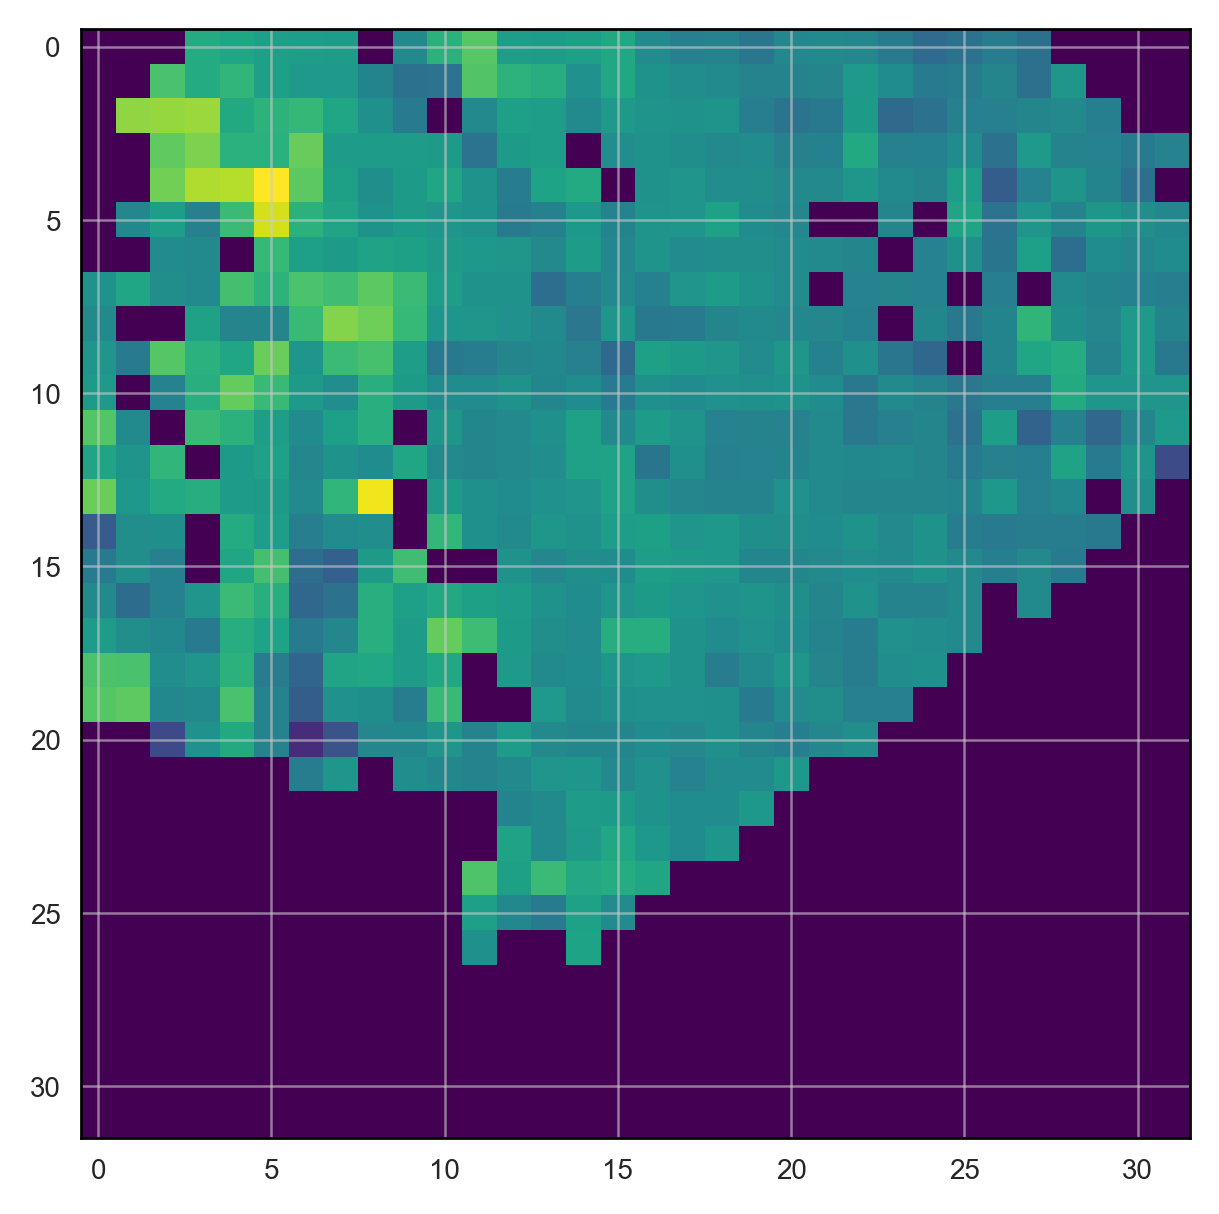

In [472]:
plt.imshow(data.x.eval[31][..., 0])

In [473]:
ic(data.y.eval[30], inv_eval_ref.model.predict(data.x.eval[30:31]))

1/1 [==============================] - 0s 18ms/step


ic| data.y.eval[30]: array([7.19049978])
    inv_eval_ref.model.predict(data.x.eval[30:31]): array([[14.398181]], dtype=float32)


(array([7.19049978]), array([[14.398181]], dtype=float32))

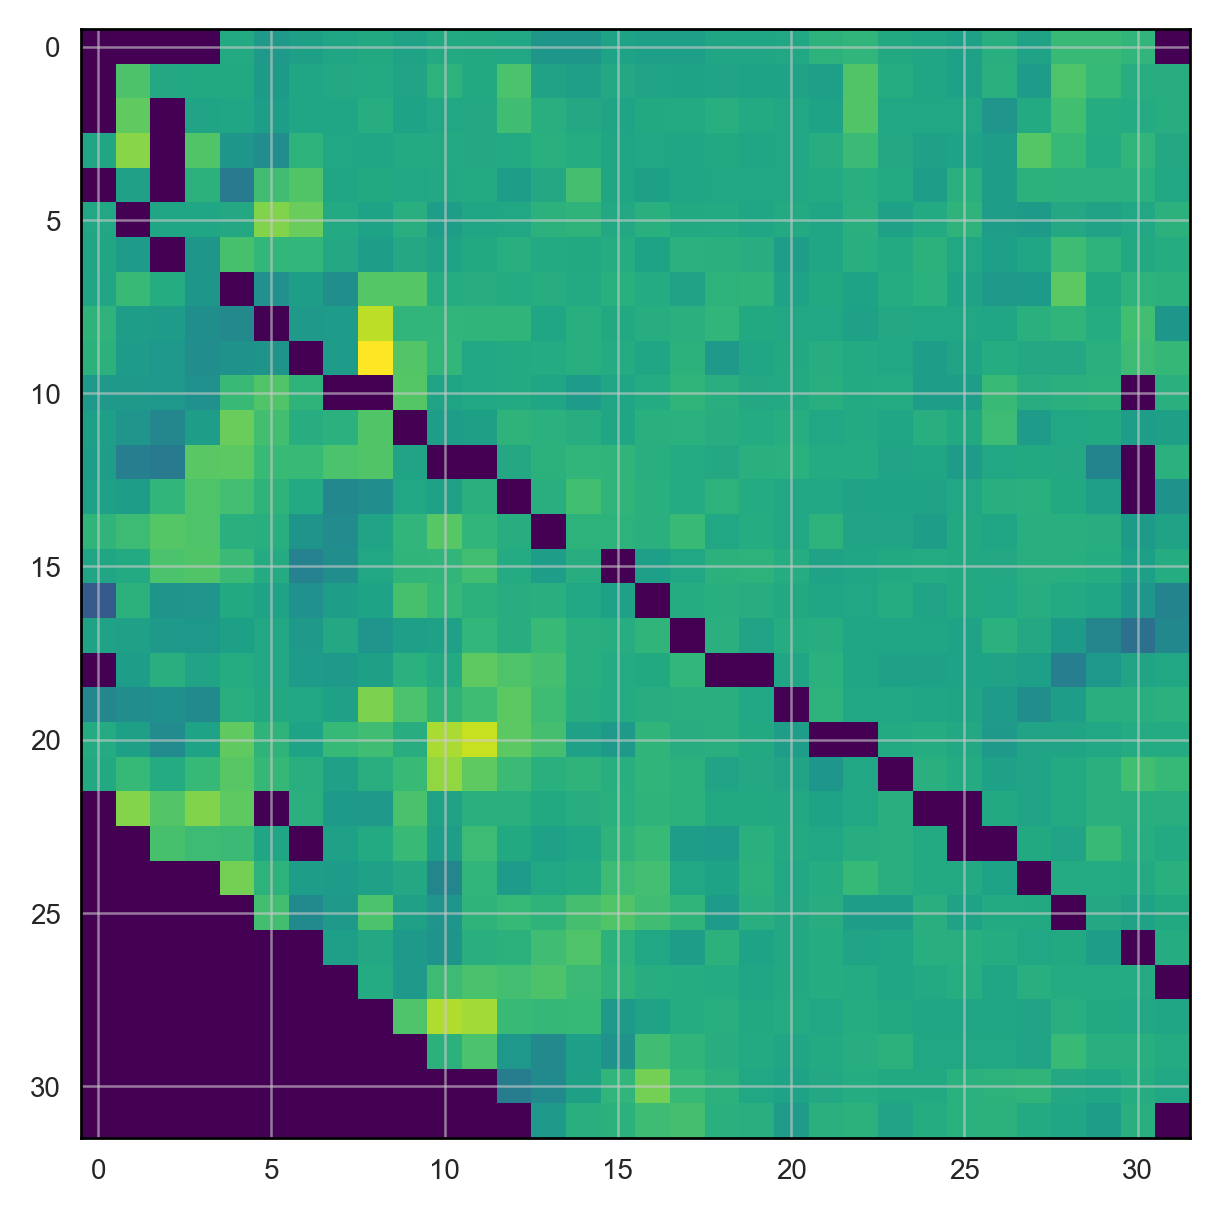

In [474]:
plt.imshow(data.x.eval[30][..., 0])

### Test

In [8]:
cfg = OmegaConf.load(os.path.join(os.path.join(dir_res, name_model), "config.yaml"))

In [9]:
cfg

{'data': {'init': {'_target_': 'Data.Data_train', 'path_train_ds': '${data.path.directory}/${data.path.train.name}/${data.path.train.nc}', 'path_valid_ds': '${data.path.directory}/${data.path.valid.name}/${data.path.valid.nc}', 'path_valid_2_ds': '${data.path.directory}/${data.path.valid_2.name}/${data.path.valid_2.nc}', 'path_extra_valid_ds': '${data.path.directory}/${data.path.extra_valid.name}/${data.path.extra_valid.nc}'}, 'input': {'dir_seg_models': '/cerea_raid/users/dumontj/dev/coco2/dl/res/models', 'chan_0': 'xco2', 'chan_1': 'u_wind', 'chan_2': 'v_wind', 'chan_3': 'None', 'chan_4': 'None', 'clouds_threshold': 0.99, 'dir_clouds_array': '/libre/dumontj/coco2/dl-input/clouds', 'timedate': False}, 'output': {'N_emissions': 1}, 'path': {'directory': '/libre/dumontj/coco2/dl-input', 'train': {'name': '2km_forOco3_32', 'nc': 'dataset.nc'}, 'valid': {'name': '2km_Dolo_32_beta_distribution_mapping', 'nc': 'dataset.nc'}, 'valid_2': {'name': '2km_Dolo_32', 'nc': 'dataset.nc'}, 'extra_val

In [37]:
data = instantiate(cfg.data.init)

data.prepare_input(
    cfg.data.input.chan_0,
    cfg.data.input.chan_1,
    cfg.data.input.chan_2,
    cfg.data.input.chan_3,
    cfg.data.input.chan_4,
    cfg.data.input.clouds_threshold,
    cfg.data.input.dir_clouds_array,
    cfg.data.input.timedate,
)
data.prepare_output_inversion(cfg.data.output.N_emissions)

In [38]:
generator = instantiate(
    cfg.augmentations,
    data.x.train,
    data.x.xco2_plumes_train,
    data.x.xco2_back_train,
    data.x.xco2_alt_anthro_train,
    getattr(data.x, "no2_plumes_train", None),
    getattr(data.x, "no2_back_train", None),
    data.y.train,
    data.x.list_chans,
    data.x.clouds_training,
    data.x.noise_layer,
    data.x.norm_layer,
    data.x.cloud_layer,
    batch_size=4000,
)

In [39]:
gen_fields, gen_emiss = generator.__getitem__(0)

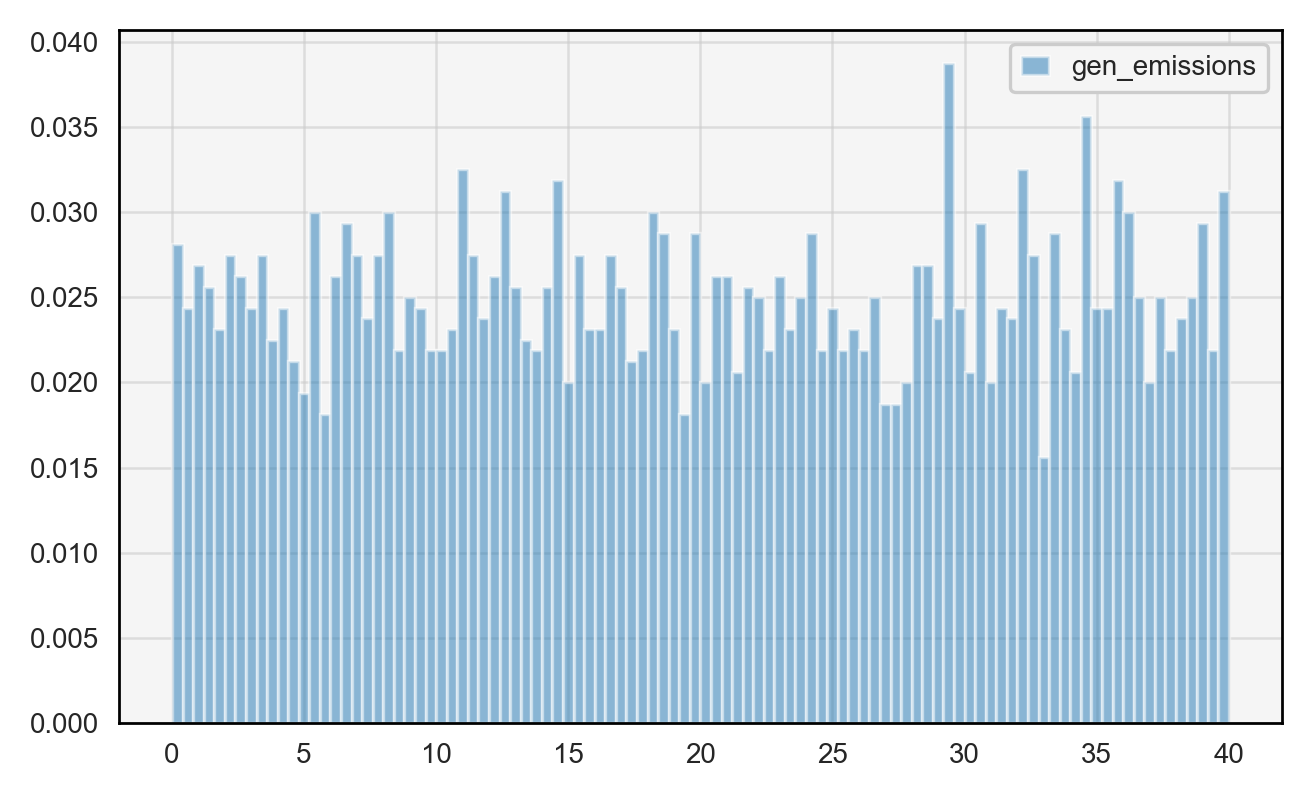

In [40]:
plt.figure(figsize=(5, 3))
plt.hist(
    np.squeeze(gen_emiss), bins=50 * 2, alpha=0.5, label="gen_emissions", density=True
)
plt.legend()

plt.show()